<a href="https://colab.research.google.com/github/ILYAGRISH/ILYAGRISH/blob/main/L07_Learning_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><a href="https://msu.ai/"><img src="https://edunet.kea.su/repo/EduNet-content/dev-2.3/msu_ai.png" width="1024"></a></center>

<font size="6">Улучшение сходимости нейросетей и борьба с переобучением</font>

В предыдущих лекциях мы познакомились с теоремой о нейронной сети в качестве [универсального аппроксиматора 🥨[colab]](https://colab.research.google.com/drive/1Rq2rAmb_rTLlm6fZZLOplh7gPnGXI07T#scrollTo=vyBYex3YG-ob) и теми преимуществами, которые может дать использование глубоких нейронных сетей. Кроме того, мы познакомились с алгоритмом [стохастического градиентного спуска 🥨[colab]](https://colab.research.google.com/drive/17CTevptz-Qm4bHqGXw0AHBYkvD74wmnF#scrollTo=UQyZ74Yr94iP), при помощи которого мы можем обучать нейронные сети решать интересующие нас задачи. К сожалению, описанный нами ранее подход в обучении глубоких сетей является не полным и на практике редко приводит к успешному решению.

В этой лекции мы продемонстрируем модельный пример такой проблемы с обучением глубокой сети и последовательно рассмотрим ряд идей, которые позволят её исправить.

# Трудности при обучении глубоких нейронных сетей

Код для визуализации результатов обучения моделей:

In [ ]:
from IPython.display import clear_output

!pip install -q lightning==2.5.0 tbparse
clear_output()

In [ ]:
def exponential_smoothing(scalars, weight):
    last = scalars[0]
    smoothed = []
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val

    return smoothed

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


class HistoryPlotter:
    def __init__(self):
        # Dict for safe learning history
        self._history_dict = {}

    def add(self, history):
        """
        Save learning history.
        history: dict with keys: model_name, epoсhs, loss_on_train, loss_on_test
        """
        self._history_dict[history["model_name"]] = history
        self.color_list = list(mcolors.TABLEAU_COLORS.keys())

    def plot(self, models, show_smooth=True, smooth_val=0.90):
        """
        Plot informatiom from self._history_dict.
        models: list of model_name (len <= 5, or extend color_list)
        """
        fig, ax = plt.subplots(3, 1, figsize=(10, 10))
        for model_num, model_name in enumerate(models):
            history = self._history_dict[model_name]
            for idx, (key, title) in enumerate(
                zip(["loss_on_train", "loss_on_test"], ["train loss", "test loss"])
            ):
                epoch_len = len(history[key]) // history["epoсhs"]
                loss_len = len(history[key])
                ticks_positions = np.arange(history["epoсhs"] + 1)

                if show_smooth:
                    x = np.arange(len(history[key])) / epoch_len
                    # Plot train loss and test loss:
                    # 1. Plot smoothing vals
                    ax[idx].plot(
                        x,
                        exponential_smoothing(history[key], smooth_val),
                        label=model_name + " smoothed",
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 2. Plot raw vals
                    ax[idx].plot(
                        x,
                        history[key],
                        label=model_name + " raw",
                        alpha=0.2,
                        color=self.color_list[2 * model_num + idx],
                    )
                    # 3. Add descriptions if it is nesessary
                    if not ax[idx].title.get_text():
                        ax[idx].set_title(title)
                        ax[idx].set_xlabel("epochs")
                        ax[idx].set_ylabel("loss")
                        ax[idx].set_xticks(ticks_positions)
                        ax[idx].set_xticklabels(np.arange(history["epoсhs"] + 1))
                    ax[idx].legend()

                # Plot mean train and test loss combined:
                # 1. Calculate mean and std
                mean_loss_on_epoch = [
                    np.mean(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                std_loss_on_epoch = [
                    np.std(history[key][i : i + epoch_len])
                    for i in range(0, loss_len, epoch_len)
                ]
                # 2. Plot
                ax[2].errorbar(
                    np.arange(history["epoсhs"]) + idx / 30.0,
                    mean_loss_on_epoch,
                    yerr=std_loss_on_epoch,
                    capsize=5,
                    fmt="X--",
                    label=model_name + " " + title,
                )
                # 3. Add descriptions if it is necessary
                if not ax[2].title.get_text():
                    ax[2].set_title("\nAverage loss per epoch", {"fontsize": 12})
                    ax[2].set_xticks(np.arange(history["epoсhs"]))
                    ax[2].set_xticklabels(np.arange(history["epoсhs"]))
                    ax[2].set_xlabel("epochs")
                    ax[2].set_ylabel("loss")
                ax[2].legend()
        plt.subplots_adjust(hspace=0.4)
        plt.show()

In [ ]:
history_plotter = HistoryPlotter()

Загрузим данные, создадим сеть, обучим ее и посмотрим на практике, как проходит обучение.

Загрузим **датасет MNIST**:

In [ ]:
import torch
import torchvision
from torchvision.transforms import v2
from IPython.display import clear_output
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

# Transforms for data
transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.13], [0.3]),
    ]
)

data_set = MNIST(root="./MNIST", train=True, download=True, transform=transform)
train_set, val_set = random_split(
    data_set, [0.8, 0.2], generator=torch.Generator().manual_seed(42)
)
test_set = MNIST(root="./MNIST", train=False, download=True, transform=transform)

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

clear_output()
print("Already downloaded!")

Already downloaded!


Создадим сеть с **сигмоидой** в качестве функции активации:

In [ ]:
import torch.nn as nn


class SimpleMNIST_NN(nn.Module):
    def __init__(self, n_layers, activation=nn.Sigmoid):
        super().__init__()
        self.n_layers = n_layers  # num of layers
        self.activation = activation()
        layers = [nn.Linear(28 * 28, 100), self.activation]  # input layer
        for _ in range(n_layers - 1):  # append num of layers
            layers.append(nn.Linear(100, 100))
            layers.append(self.activation)
        layers.append(nn.Linear(100, 10))  # 10 classes
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # reshape to [-1, 784]
        x = self.layers(x)
        return x

Реализуем пайплайн обучения модели на Lightning.

[[colab] 🥨 Основы работы с Lightning](https://colab.research.google.com/drive/16Q_k7NR4oGMh5CrqErsdzWwpihlK4lbH)

In [ ]:
import torch
import lightning as L


class Pipeline(L.LightningModule):
    def __init__(
        self,
        model,
        exp_name="baseline",
        criterion=nn.CrossEntropyLoss(),
        optimizer_class=torch.optim.SGD,
        optimizer_kwargs={"lr": 0.001},
    ) -> None:
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_kwargs = optimizer_kwargs

        # Additionally, we will save training logs “manually”
        # for visualization within the lecture. Please limit yourself
        # to the native training logging tools from Pytorch Lightning
        # when training your own models.
        self.history = {"loss_on_train": [], "loss_on_test": [], "model_name": exp_name}

    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_train", loss, prog_bar=True)

        # Aux logging for lecture visualization
        self.history["loss_on_train"].append(loss.cpu().detach().item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_test", loss, prog_bar=True)

        # Aux logging for lecture visualization
        self.history["loss_on_test"].append(loss.cpu().detach().item())

Создадим и запустим обучение модели с **двумя скрытыми слоями** и одним выходным слоем:

In [ ]:
model_name = "n_layers2_sigmoid"
model = SimpleMNIST_NN(n_layers=2)

print(model)

SimpleMNIST_NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger


trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name)

trainer.fit(
    model=pipeline,
    train_dataloaders=train_loader,
    val_dataloaders=val_loader,
)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SimpleMNIST_NN   | 89.6 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
89.6 K    Trainable params
0         Non-trainable params
89.6 K    Total params
0.358     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callb

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
history_plotter.plot([model_name])

А теперь посмотрим на модель **с тремя скрытыми слоями** и одним выходным слоем:

In [ ]:
model_name = "n_layers3_sigmoid"
model = SimpleMNIST_NN(n_layers=3)
print(model)

SimpleMNIST_NN(
  (activation): Sigmoid()
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [ ]:
trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SimpleMNIST_NN   | 99.7 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callb

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
history_plotter.plot(["n_layers2_sigmoid", model_name])

**Замечание:** На самом деле, если увеличить learning rate, размер батча или число нейронов, то нейросеть начнет учиться. Это учебный пример, чтобы показать, что такое бывает.

Нейросеть с тремя слоями вообще **не учится**. Почему? Попробуем разобраться.

Для этого напишем функции, которые будут следить за **распределением градиентов** и **активаций** на наших слоях.

Воспользуемся методами `register_forward_hook` и `register_backward_hook` из библиотеки PyTorch для того, чтобы выполнять эти функции при запуске прямого или обратного распространения через нашу сеть.

*Комментарий к коду:*

В коде ниже используются [замыкания (closure) ✏️[blog]](https://habr.com/ru/articles/781866/). Это функции, определяющие и возвращающие другие функции. Они нужны, чтобы передавать в [пространство имен ✏️[blog]](https://realpython.com/python-namespaces-scope/) вложенной функции дополнительные переменные. Функции `get_forward_hook` и `get_backward_hook` — это замыкания.

Зачем такие сложности? Дело в том, что регистрируемые в `child.register_forward_hook` и `child.weight.register_hook` функции должны иметь фиксированное количество переменных на входе: для `forward_hook` — `(self, input_, output)` (названия, кроме `self`, могут варьироваться), для `backward_hook` — `(grad)` (название может варьироваться).

Мы хотим сохранить значения карт признаков и градиентов. Для хранения значений мы используем словарь листов `defaultdict(list)`, который определяем в функции  `register_model_hooks` в переменную `history_dict`. Словарь в Python является [изменяемым (mutable) ✏️[blog]](https://realpython.com/python-mutable-vs-immutable-types/#:~:text=Python%20has%20both%20mutable%20and,dictionaries%2C%20and%20sets%20are%20mutable.) объектом. Мы передаем в функции  `get_forward_hook` и `get_backward_hook` ссылку на словарь, куда нужно записывать интересные нам данные, и ключ для словаря. Так мы извлекаем значения из сети.



In [ ]:
from collections import defaultdict


def get_forward_hook(history_dict, key):
    def forward_hook(self, input_, output):
        history_dict[key] = input_[0].cpu().detach().numpy().flatten()

    return forward_hook


def get_backward_hook(history_dict, key):
    def backward_hook(grad):  # for tensors
        history_dict[key] = grad.abs().cpu().detach().numpy().flatten()

    return backward_hook


def register_model_hooks(model):
    cur_ind = 0
    history_dict = defaultdict(list)
    for child in model.layers.children():
        if isinstance(child, nn.Linear):
            forward_hook = get_forward_hook(history_dict, key=f"sigmoid_out_{cur_ind}")
            child.register_forward_hook(forward_hook)

            cur_ind += 1
            backward_hook = get_backward_hook(
                history_dict, key=f"gradient_linear_{cur_ind}"
            )
            child.weight.register_hook(backward_hook)
    return history_dict

Запустим обучение **модели с тремя слоями**:

In [ ]:
model_name = "n_layers3_sigmoid2"
model = SimpleMNIST_NN(n_layers=3)

hooks_data_history = register_model_hooks(model)

trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SimpleMNIST_NN   | 99.7 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callb

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


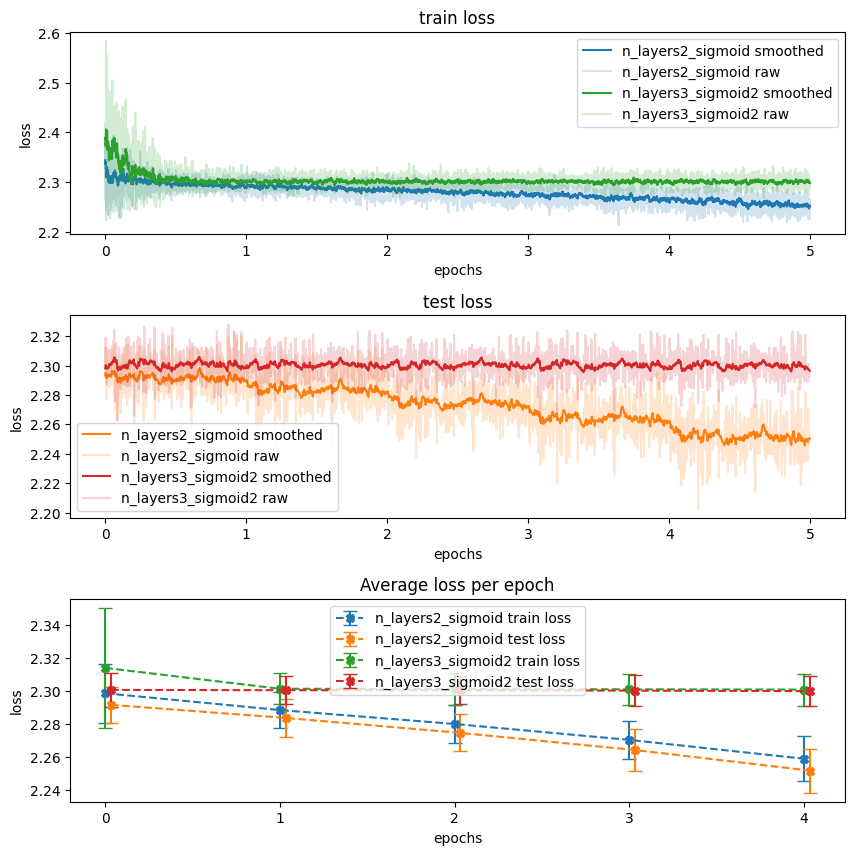

In [ ]:
history_plotter.plot(["n_layers2_sigmoid", model_name])

In [ ]:
def plot_hooks_data(hooks_data_history):
    keys = hooks_data_history.keys()
    n_layers = len(keys) // 2

    activation_names = [f"sigmoid_out_{i}" for i in range(1, n_layers)]
    activations_on_layers = [
        hooks_data_history[activation] for activation in activation_names
    ]

    gradient_names = [f"gradient_linear_{i + 1}" for i in range(n_layers)]
    gradients_on_layers = [hooks_data_history[gradient] for gradient in gradient_names]

    for plot_name, values, labels in zip(
        ["activations", "gradients"],
        [activations_on_layers, gradients_on_layers],
        [activation_names, gradient_names],
    ):
        fig, ax = plt.subplots(1, len(labels), figsize=(14, 4), sharey="row")
        for label_idx, label in enumerate(labels):
            ax[label_idx].boxplot(values[label_idx], tick_labels=[label])
        plt.show()

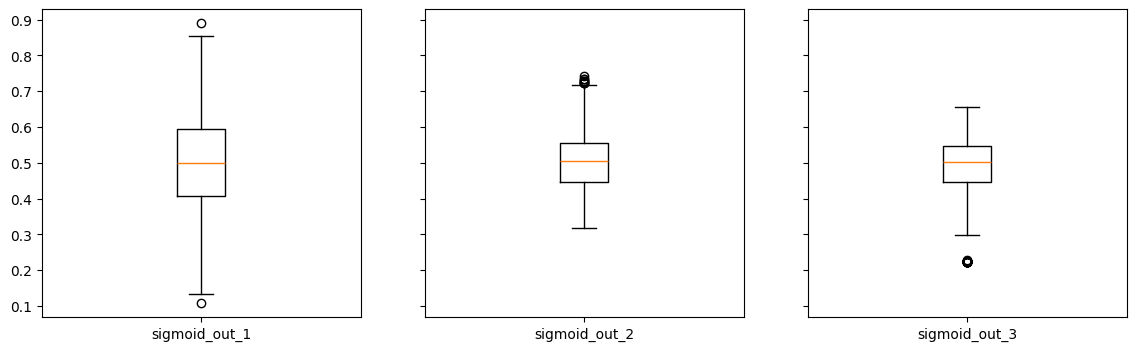

In [ ]:
plot_hooks_data(hooks_data_history)

Мы видим, что градиент модели стремительно затухает. Первые слои, до которых градиент доходит последним, получают значения градиента, мало отличимые от нуля.



# Затухание градиента

Откуда оно берется?

Посмотрим на обычную сигмоиду:

$$\sigma(z) = \dfrac 1 {1 + e^{-z}}$$

Ее производная, как мы уже выводили, равна:

$$\dfrac {\partial \sigma(z)} {\partial z} = \sigma(z) (1 - \sigma(z))$$

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/activation_function_sigmoid.png" width="1000"></center>

Какое максимальное значение у такой функции?

Сигмоида находится в пределах от $0$ до $1$. **Максимальное значение производной** сигмоиды  $=\dfrac 1 4$.

Теперь возьмем простую нейронную сеть:


<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/simple_nn_with_sigmoid.png" width="750">

Посчитаем у нее градиент:

$$\dfrac {\partial L} {\partial z_4} = \dfrac {\partial L} {\partial y} \dfrac {\partial y} {\partial z_4} = \dfrac {\partial L} {\partial y} \dfrac {\partial \sigma(w_5z)} {\partial z} w_5 \le \dfrac 1 4 \dfrac {\partial L} {\partial y}  w_5 $$

Аналогично можно посчитать градиент для $z_3$:

$$\dfrac {\partial L} {\partial z_3} = \dfrac {\partial L} {\partial z_4} \dfrac {\partial z_4} {\partial z_3} \le \dfrac {\partial L} {\partial y} \dfrac {\partial \sigma(w_4z)} {\partial z} w_5 \le \left({\dfrac 1 4}\right)^2 \dfrac {\partial L} {\partial y}  w_5 w_4$$

И так далее:

$$\dfrac {\partial L} {\partial x}  \le \left({\dfrac 1 4}\right)^5 \dfrac {\partial L} {\partial y}  w_5 w_4 w_3 w_2 w_1$$

Таким образом, при **маленьких весах** градиент начинает **экспоненциально затухать**.

При **больших весах**, из-за chain-rule, может происходить **взрыв градиента**. Взрыву градиента особенно подвержены рекуррентные нейронные сети, о которых будет рассказано позже (в них сигналы пропускаются через один и тот же блок с одними и теми же весами), а также сети с использованием SoftMax (это происходит в архитектурах трансформеров).

Для некоторых функций активации картина будет не столь катастрофична, но тоже неприятна.
При выполнении заданий вы посмотрите, например, как ведет себя функция **ReLU** в этом случае.

Давайте подумаем, что можно сделать с нейронной сетью, чтобы она начала учиться. В начале рассмотрим методы, **не изменяющие структуру сети** (без добавления дополнительных слоев), также зафиксируем количество нейронов и параметры оптимизатора.


# Нормализация входов и выходов

Начнем с уже знакомого: **нормализация**.

## Нормализация входных данных

Представим себе, что данные, которые мы подаем в нейросеть, распределены следующим образом:

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/data_before_normalization.png" width="400"></center>

Фактически нейросети работают со скалярными произведениями. В этом плане два вектора, изображенные на рисунке, **не сильно отличаются**. Также и точки нашего датасета слабо разделимы. Чтобы с этим работать, нейросеть сначала должна подобрать **удобное преобразование**, а затем сравнивать объекты. Понятно, что это усложняет задачу.

Для того, чтобы облегчить нейросети задачу, входные признаки часто **нормируют**:

$$x1' = \dfrac {x1 - \mu_{x1}} {\sigma_{x1}}$$

$$x2' = \dfrac {x2 - \mu_{x2}} {\sigma_{x2}}$$

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/data_after_normalization.png" width="450"></center>


 Такое преобразование действительно помогает нейросети:

$$ \large J(w,b) = \frac1m \sum L(\hat{y^i}, y^i)$$

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/normalization_helps_find_minimum_of_function.png" width="700"></center>

<center><em>Нормализация позволяет искать минимум целевой функции удобнее и быстрее</em></center>


## Нормализация целевых значений в задаче регрессии

В ряде приложений также нужна **нормализация выходных значений**, например, в задаче **регрессии**. Существует несколько причин, почему это необходимо.

### Взрыв градиента

В большинстве случаев мы **нормализуем входные данные**, чтобы среднее значение было равно $0$.

In [ ]:
import torch
import matplotlib.pyplot as plt

x = torch.randn((512, 100))  # Fake normalized data
plt.hist(x.mean(dim=0), bins=20)
plt.show()
print(f"X mean: {x.mean().item():.2f} X variance: {x.var().item():.2f}")

X mean: 0.00 X variance: 0.99


Кроме этого мы определенным **случайным** образом инициализируем веса.

In [ ]:
from torch import nn

net = nn.Sequential(
    nn.Linear(100, 50),  # weights randomly sampled from some random distribution
    nn.Sigmoid(),
    nn.Linear(50, 1),
)

Веса **нормально распределены вокруг нуля**:




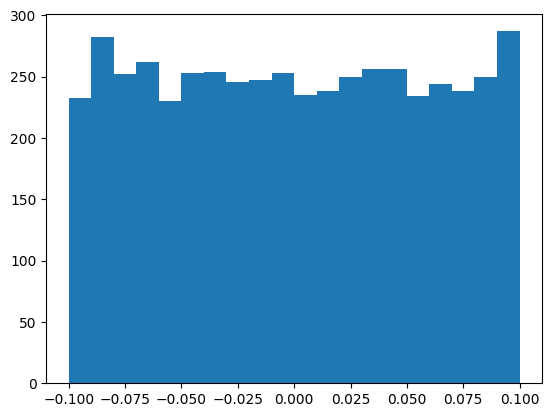

Weights mean: 0.00,  Weights variance: 0.00


In [ ]:
weights = net[0].weight.data.numpy()
plt.hist(weights.flatten(), bins=20)
plt.show()

print(f"Weights mean: {weights.mean():.2f},  Weights variance: {weights.var():.2f}")

Необученная сеть будет чаще всего предсказывать значения порядка $10^{-1}$.

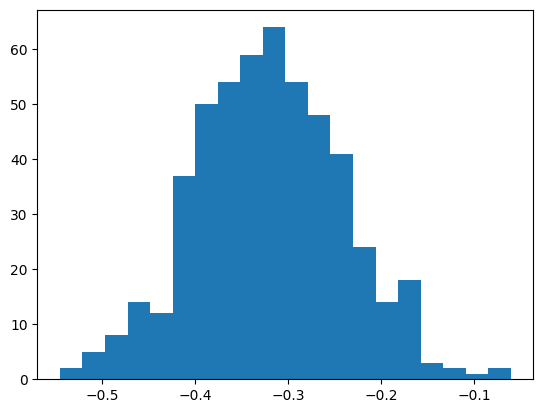

Out mean: -0.32, Out variance: 0.01


In [ ]:
out = net(x)
plt.hist(out.detach().numpy(), bins=20)
plt.show()

print(f"Out mean: {out.mean().item():.2f}, Out variance: {out.var().item():.2f}")

Предположим, мы предсказываем какую-то большую величину. Например, [стоимость дома в штате Калифорния в долларах 🛠️[doc]](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) (в датасете в Sklearn целевое значение нормировано на $100\ 000\$$). Стоимость лежит в диапазоне от $15\ 000\$$ до $500\ 000\$$.

Выберем случайные значения в этом диапазоне.

In [ ]:
# fake cost
targets = torch.randint(15_000, 500_000, (512, 1), dtype=torch.float32)
print(f"Target example: {targets[:10].flatten()}")

Target example: tensor([346701., 449697., 361609., 328642., 281345., 372201., 139900., 390598.,
        224951., 104170.])


Если мы будем пытаться предсказывать эти значения, мы получим **очень большую ошибку**.

In [ ]:
criterion = nn.MSELoss()
loss = criterion(out, targets)
loss.backward()

print(f"Loss: {loss.item():.2f}")

Loss: 82483396608.00


Эта ошибка приведет к **большим значениям градиента** (cмотрим на значения по оси абсцисс), **большим значениям весов** и **нестабильному обучению**.

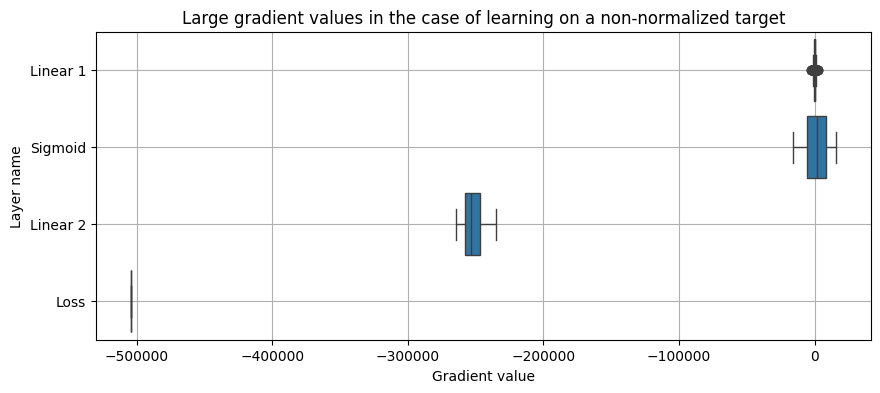

In [ ]:
import pandas as pd
import seaborn as sns

layer_names = ("Linear 1", "Sigmoid", "Linear 2", "Loss")
gradient_values = {}
for layer_name, p in zip(layer_names, net.parameters()):
    gradient_values[layer_name] = pd.Series(p.grad.detach().flatten().numpy())

gradient_values = pd.DataFrame(gradient_values)
data_to_plot = gradient_values.melt(value_name="Gradient value", var_name="Layer name")

plt.figure(figsize=(10, 4))
sns.boxplot(data=data_to_plot, x="Gradient value", y="Layer name")
plt.grid()
plt.title(f"Large gradient values in the case of learning on a non-normalized target")
plt.show()

Если мы **стандартизуем целевые значения**:

In [ ]:
mean = targets.float().mean()
std = targets.float().std()

transformed_targets = (targets - mean) / std
print(transformed_targets.flatten()[:10])

tensor([ 0.6869,  1.4347,  0.7952,  0.5558,  0.2124,  0.8721, -0.8146,  1.0056,
        -0.1971, -1.0740])


То получим ошибку на 10 порядков **меньше**:

In [ ]:
net.zero_grad()
out = net(x)
loss = criterion(out, transformed_targets)
loss.backward()

print(f"Loss: {loss.item():.2f}")

Loss: 1.11


И **небольшие градиенты** (cмотрим на значения по оси абcцисс):


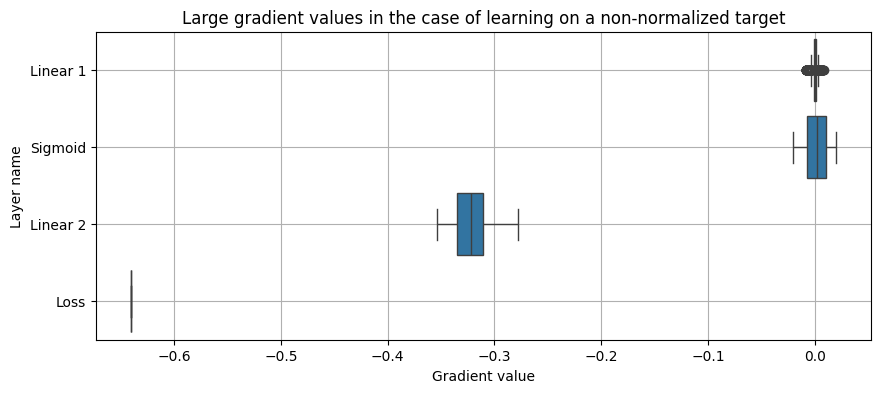

In [ ]:
layer_names = ("Linear 1", "Sigmoid", "Linear 2", "Loss")
gradient_values = {}
for layer_name, p in zip(layer_names, net.parameters()):
    gradient_values[layer_name] = pd.Series(p.grad.detach().flatten().numpy())

gradient_values = pd.DataFrame(gradient_values)
data_to_plot = gradient_values.melt(value_name="Gradient value", var_name="Layer name")

plt.figure(figsize=(10, 4))
sns.boxplot(data=data_to_plot, x="Gradient value", y="Layer name")
plt.grid()
plt.title(f"Large gradient values in the case of learning on a non-normalized target")
plt.show()

### Multi-Dimensional регрессия

В ряде задач, например, при [**использовании нейронных сетей для моделирования физических процессов** 🎓[arxiv]](https://arxiv.org/abs/2007.13875), в задаче регрессии, необходимо вычислять **несколько целевых значений**. При этом необходимо помнить, что в качестве функционала ошибки в задачах регрессии часто выбирается **метрика расстояния**, а физические величины могут иметь **различный порядок** и **диапазон значений**.

Не самая лучшая идея — считать расстояние, когда по одной оси отложены нанометры, а по другой — килограммы.


В физических задачах полезно изучить, какие нормировки используют в **численных методах** для получения [безразмерных (**dimensionless**) величин 📚[book]](https://www.physics.umd.edu/perg/MathPhys/content/2/pstruc/dimsDE.htm). Это может подсказать хорошую, физически обоснованную нормировку.


# Инициализация весов

Одним из способов борьбы с затухающим градиентом является правильная **инициализация весов**. Как это сделать?

**Идея 1:** инициализировать все веса константой.

Проблема: градиент по всем весам будет одинаков, как и обновление весов. Все нейроны в слое будут учить одно и то же, или, в случае $\text{const} = 0$ и активации $\text{ReLU}$, [не будут учиться вообще ✏️[blog]](https://habr.com/ru/post/592711/).

**Вывод:** в качестве начальных весов нужно выбирать различные значения.

**Идея 2:** инициализировать веса нормальным (Гауссовским) шумом с матожиданием $0$ и маленькой дисперсией.

Маленькая дисперсия нужна, чтобы не получить огромные градиенты за большие изначальные ошибки в предсказании.

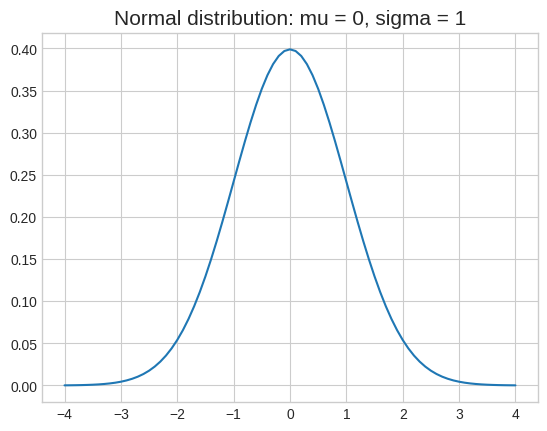

In [ ]:
# Normal distribution: mu = 0, sigma = 1

x = np.arange(-4, 4.1, 0.1)
y = np.exp(-np.square(x) / 2) / np.sqrt(2 * np.pi)

plt.style.use("seaborn-v0_8-whitegrid")
plt.title("Normal distribution: mu = 0, sigma = 1", size=15)
plt.plot(x, y)
plt.show()

**Проблема:** инициализация нормальным шумом не гарантирует отсутствие взрыва или затухания градиента.

**Идея 3:** формализуем условия, при которых взрыв и затухание градиентов не будут происходить.

1. Нам бы хотелось, чтобы **дисперсии признаков**, получаемых на каждом слое, были одинаковы (т.е мы хотим задать начальные веса таким образом, чтобы входные признаки каждого линейного слоя были **одинаково нормализованы**).

Это важно, т.к. значения признаков используются при расчете градиента. Например, для линейного слоя:

$$y = wx+b$$
$$\dfrac{\partial y} {\partial w} = x$$

Запишем это условие:

$$Dz^i = Dz^j \tag{1}$$

2. Нам бы хотелось, чтобы **дисперсии градиентов** для разных слоев были одинаковы:

$$D\dfrac {\partial L} {\partial z^i} = D\dfrac {\partial L} {\partial z^j} \tag{2}$$


При выполнении этих условий градиент **не затухает** и **не взрывается**.

Инициализации Ксавье и Каймин Хе выводятся из этих условий.

## Инициализация Ксавье (Xavier Glorot)

Инициализация Ксавье была предложена в статье [Understanding the difficulty of training deep feedforward neural networks (Xavier et al., 2010) 🎓[article]](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). Она используется для симметричных функций активации (**Sigmoid**, **Tanh**).

При инициализации весов [равномерным распределением 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%9D%D0%B5%D0%BF%D1%80%D0%B5%D1%80%D1%8B%D0%B2%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D0%B2%D0%BD%D0%BE%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5) условия (1) и (2) преобразуются в:

 $$W_i \sim U[-\sqrt{\dfrac {6} {n_i + n_{i + 1}}}, \sqrt{\dfrac {6} {n_i + n_{i + 1}}}],$$

где $n_i$ — размерность выхода $i$-го слоя.

При инициализации весов [нормальным распределением 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%9D%D0%BE%D1%80%D0%BC%D0%B0%D0%BB%D1%8C%D0%BD%D0%BE%D0%B5_%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5) условия (1) и (2) преобразуются в:

$$W_i \sim N (0,  \text{std}=\sqrt{\dfrac{2}{n_i + n_{i + 1}}})$$

Можно использовать любое распределение.

## Инициализация Каймин Хе (Kaiming He)

Инициализация Каймин Хе была предложена в статье
[Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification (He et al., 2015) 🎓 [arxiv]](https://arxiv.org/pdf/1502.01852v1.pdf). Она используется для функции активации **ReLU** и ее модификаций (**PReLU**, **Leaky ReLU** и т.д.).

При инициализации весов нормальным распределением условия (1) и (2) преобразуются в:

$$W_i \sim N(0, \text{std}=\sqrt{\frac 2 {n_i}})$$

Для равномерного распределения:
$$W_i \sim U(-\sqrt{\frac 3 {n_i}}, \sqrt{\frac 3 {n_i}})$$



Подробный вывод формул:

[[colab] 🥨 Инициализация весов](https://colab.research.google.com/drive/1RzBp0oBmX5HoiptrsGHQ9qKB1GFFfx44)

## Важность инициализации весов

Инициализация весов существенно влияла на возможность обучения до появления слоев нормализации, о которых вы узнаете далее. При наличии слоев нормализации она лишь немного ускоряет сходимость в начале обучения.

Посмотрим на результаты из статьи [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification (He et al., 2015) 🎓[arxiv]](https://arxiv.org/pdf/1502.01852v1.pdf) (они получены **без слоев нормализации**).

1. Нейросеть может **сойтись значительно быстрее**. Графики для активации **ReLU**:


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/weight_initialization_influence_convergence_neural_networks.png" width="600"></center>

<center><em>Обучение нейронной сети с 22 слоями при использовании инициализации Kaiming He и Xavier</em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1502.01852v1.pdf">Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification</a></em></center>



2. В зависимости от выбранной активации сеть вообще может **сойтись или не сойтись**. Графики для активации **ReLU**:

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/activation_function_influence_convergence_neural_networks.png" width="600"></center>

<center><em>Обучение нейронной сети с 30 слоями при использовании инициализации He и Xavier</em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1502.01852v1.pdf">Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification</a></em></center>

## Инициализация весов в PyTorch

Для инициализации весов в PyTorch используется модуль `torch.nn.init`, в котором для этого определены разные функции.

Нюанс состоит в том, что обычно для слоев разного типа может требоваться разная инициализация. Поэтому в функции, которая инициализирует слои вашей нейронной сети, желательно прописывать разное поведение для разных слоев.

Попробуем, например, добавить в нашу нейросеть инициализацию. Нам нужна инициализация Xavier, так как у нас `nn.Sigmoid`.

Метод `torch.nn.init.calculate_gain` возвращает рекомендуемое значение коэффициента масштабирования для стандартного отклонения заданной функции активации. Не забывайте его использовать для `torch.nn.init.xavier_normal_`.

Напишем функцию `init_weights` (ее тоже можно обернуть в замыкание, чтобы случайно не поменять `init_gain`) и применим ее к нашей модели с помощью `nn.Module.apply` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.apply), применяющему функцию ко всем подмодулям модели.

In [ ]:
activation_type = "sigmoid"
init_gain = torch.nn.init.calculate_gain(activation_type)


def init_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        torch.nn.init.xavier_normal_(m.weight, gain=init_gain)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

Запустим обучение модели с инициализацией весов Xavier:

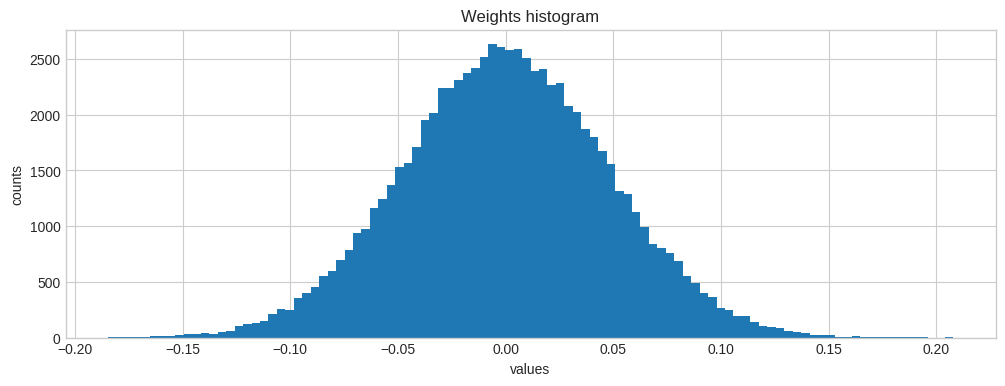

In [ ]:
model_name = "n3_layers_sigmoid_havier"
model = SimpleMNIST_NN(n_layers=3)
model.apply(init_weights)

# Plotting weights values of first (input) layer
plt.figure(figsize=(12, 4))
plt.hist(
    list(model.layers.children())[0].weight.cpu().detach().numpy().reshape(-1), bins=100
)
plt.title("Weights histogram")
plt.xlabel("values")
plt.ylabel("counts")
plt.show()

In [ ]:
trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | SimpleMNIST_NN   | 99.7 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callb

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
history_plotter.plot(["n_layers3_sigmoid", model_name])

Видим, что нейросеть стала хоть как-то учиться.

# Слои нормализации

## Internal covariate shift

На лекции 4 вы познакомились с ковариантным сдвигом целевых значений — явлением, когда признаки тренировочной и тестовой выборок **распределены по-разному**.

В [статье про Batch Normalization 🎓[arxiv]](https://arxiv.org/pdf/1502.03167.pdf) авторы предположили, что похожее явление имеет место внутри нейросети, назвав его **internal covariate shift**.

**Internal covariate shift** — это изменение распределения выхода слоя активации из-за изменения обучаемых параметров во время обучения.



<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/internal_covariate_shift_example.png" width="1000">

Пусть у нас $k$-ый нейрон $i$-го слоя переводит выход $i$−1 слоя с распределением <font color='#F9B041'>$f^{(j)}_{i-1}(x)$</font> в новое пространство с распределением <font color='#5D5DA6'>$f^{(k)}_{i}(x)$</font>.

При обучении:
- нейросеть делает предсказание,
- считается значение функции потерь,
- делается обратное распространение ошибки,
- обновляются веса.


После обновления весов $k$-ый нейрон $i$-го слоя будет переводить выходы $i$−1 слоя <font color='#F9B041'>$f^{(j)}_{i-1}(x)$</font> в пространство с другим распределением <font color='#5D5DA6'>$f^{*(k)}_{i}(x)$</font>.

При этом $i$+1 слой учился работать со старым распределением  <font color='#5D5DA6'>$f^{(k)}_{i}(x)$</font>, и будет хуже обрабатывать <font color='#5D5DA6'>$f^{*(k)}_{i}(x)$</font>.

### Плохой вариант борьбы с этим

Можно на каждом слое нормировать **каждый признак** (выход каждого нейрона), используя среднее и дисперсию по батчу:

$$ \hat{x}_{i} = \frac{x_{i} - \mu_{B}}{\sigma_{B} + \epsilon}$$




Проблема в том, что таким образом мы можем попасть в область линейной составляющей нашей функции. Например, в случае сигмоиды:

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/domain_of_linear_of_sigmoid_function.png" width="500"></center>

Получаем набор линейных слоев фактически без функций активации, следовательно, все вырождается в однослойную сеть. Не то, что нам надо.

## Batch Normalization

Надо дать нейронной сети **возможность перемещать распределение выходов** слоя из области $0$ и самой **подбирать дисперсию**. Для этой цели используется **батч-нормализация** (*batch normalization*), которая вводит в нейронную сеть дополнительную операцию между соседними скрытыми слоями.

Она состоит из **нормализации** входящих (в слой батч-нормализации) значений, полученных от скрытого слоя, **масштабирования** и **сдвига** с применением двух новых параметров и передачи полученных значений на вход следующему скрытому слою.

 <center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batchnormalization.png" width="400"> </center>

Параметры, используемые в батч-нормализации ($\gamma$ — параметр, отвечающий за **сжатие**, и $\beta$ — параметр, отвечающий за **сдвиг**), являются **обучаемыми параметрами** (наподобие весов и смещений скрытых слоев).

Помимо обучаемых параметров $\gamma$ и $\beta$ в слое батч-нормализации существуют также необучаемые параметры: **скользящее среднее матожидания** (_Mean Moving Average_) и **скользящее среднее дисперсий** (_Variance Moving Average_), служащие для сохранения состояния слоя батч-нормализации.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batchnorm_layer_parameters.png" width="900"></center>

Параметры $\gamma$, $\beta$, а также оба скользящих средних вычисляются для каждого слоя батч-нормализации отдельно и являются векторами с **длиной, равной количеству входящих признаков.**

В процессе обучения мы подаем в нейронную сеть **по одному мини-батчу за раз**. Процедуру обработки значений одного признака $x^{(k)}$ (фиолетовая колонка на изображении ниже), который для краткости мы будем обозначать $x$,  из одного мини-батча $ B = \{x_{1},\ldots, x_{m}\} $ можно представить следующим образом:



<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batch_normalization_compute_moving_average.png" width="1000"></center>

Шаг **масштабирования** Gamma ($γ$) и шаг **сдвига** Beta ($β$) являются главным новшеством батч-нормализации, поскольку, в отличие от предыдущего рассмотренного примера, нормированные значения больше не обязаны иметь среднее, равное $0$, и единичную дисперсию. Батч-нормализация позволяет сдвигать среднее нормированных значений и масштабировать дисперсию. Фактически теперь **нейросеть даже может отменить нормализацию входных данных, если считает ее ненужной.**

Для наглядности проиллюстрируем размерности промежуточных переменных на следующем изображении:

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batch_normalization_compute_moving_average_scheme.png" width="1000">

После прямого прохода параметры $\gamma$ и $\beta$ **обновляются через обратное распространение ошибки** так же, как и веса скрытых слоев.

### Скользящее среднее

Выше мы обсуждали то, что в процессе обучения слой **батч-нормализации** рассчитывает значение **среднего и дисперсии** каждого признака в соответствующем **мини-батче**. Предположим, что нам нужно сделать предсказание на **одном объекте**. Во время предсказания батч у нас уже отсутствует. Откуда брать среднее и дисперсию?

Во время предсказания используется **скользящее среднее**, которое было **рассчитано и сохранено в процессе обучения**.

$$\large \mu_{mov_{B}} = (1-\alpha)\mu_{mov_{B-1}}+\alpha\mu_{B} $$

$$\large \sigma_{mov_{B}} = (1-\alpha)\sigma_{mov_{B-1}}+\alpha\sigma_{B} $$

Обычно используется параметр $\alpha = 0.1$

Для перевода модели из режима обучения в режим тестирования и обратно в PyTorch используются `model.train()` и `model.eval()`.

$$
\begin{array}{c|c}
\large{\text{model.train()}}&\ \large{\text{model.eval()}}\\  \hline
\large{\text{Батч-нормализация использует статистику по батчу}}&\large{\text{Батч-нормализация использует скользящие средние}}\\
\large{\text{Cкользящие средние копятся}}
\end{array}
$$



Почему используется именно **скользящее среднее**, а **не статистика всей обучающей выборки**?

При таком подходе нам бы пришлось хранить **средние всех признаков** для **всех батчей**, пропущенных через нейросеть в ходе обучения. Это ужасно невыгодно по памяти. Вместо этого **скользящее среднее** выступает в качестве приближенной оценки **среднего и дисперсии** обучающего набора. В этом случае эффективность использования ресурсов увеличивается: нам нужно **хранить в памяти только одно число** — значение скользящего среднего, полученное на последнем шаге.

Проиллюстрировать преимущество использования скользящего среднего можно на следующем примере:

Предположим, что у нас есть массив объектов, обладающих некоторым признаком $x$ (обучающая выборка), и некоторый черный ящик, извлекающий по $k$ объектов из этого массива (Data loader). Наша задача — дать оценку ожидаемому среднему этих $k$ объектов. В данном примере для простоты будем извлекать $k$ объектов из некоего распределения случайным образом.

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

k = 500  # sample size
n = 2
p = 0.5

sample = np.random.negative_binomial(n, p, k)
sns.histplot(data=sample, discrete=True)
plt.show()

Оценить ожидаемое среднее теоретически, не зная, как распределен признак $x$ наших объектов, трудно. Мы можем собрать **большое количество средних** и произвести оценку с их помощью, но для этого нам потребуется хранить в памяти все эти значения, что приведет к неэффективному расходу ресурсов. Более эффективным решением будет воспользоваться **скользящим средним**. Давайте сравним эти два метода:

In [ ]:
ema = 0
alpha = 0.01
means = np.array([])

for i in range(10000):
    sample = np.random.negative_binomial(n, p, 50)
    ema = (1 - alpha) * ema + alpha * sample.mean()
    means = np.append(means, sample.mean())

Посчитаем количество памяти, затрачиваемое на хранение списка средних значений признака $x$ по выборкам из $k$ объектов, и **количество памяти**, затрачиваемое на хранение **скользящего среднего**:

In [ ]:
import sys

print(f"{sys.getsizeof(ema)} bytes")

32 bytes


Количество памяти для хранения **списка средних**:

In [ ]:
print(f"{sys.getsizeof(means)} bytes")

80112 bytes


Видно, что на хранение массива средних значений расходуется на порядки больше памяти, чем на хранение одного скользящего среднего. Теперь давайте воспользуемся тем, что мы семплировали случайные выборки из известного распределения, и можем теоретически рассчитать их среднее. В нашем примере мы извлекали выборки из негативного биномиального распределения с параметрами $n=2$ и $p=0.5$, для которого среднее рассчитывается по формуле: $$\text{mean}=\dfrac{np}{1-p}=2$$

Мы знаем, что при достаточно большом количестве семплированных выборок среднее распределения выборочных средних будет стремиться к среднему генеральной совокупности. Сравним результаты, полученные с использованием сохраненных выборочных средних и скользящего среднего, с теоретическим расчетом.

Среднее признака $x$ по $k$ объектам, оцененное с помощью **скользящего среднего**:

In [ ]:
print(f"{ema:.8f}")

2.02125420


Среднее признака $x$ по $k$ объектам, **оцененное по всем семплированным выборкам**:

In [ ]:
print(f"{means.mean():.8f}")

1.99802600


Видно, что мы получили довольно точную оценку, использовав скользящее среднее.

### Защита от нулей в знаменателе

Чтобы у нас не мог возникнуть $0$ в знаменателе, добавляем маленькое число — $\epsilon$. Например, $\epsilon = 10^{-5}$.


$$\large \hat{x}_{i} = \frac{x_{i} - \mu_{B}}{\sigma_{B} + \epsilon}$$

$$\large \text{BN}_{\gamma, \beta}(x_{i}) = \gamma \hat{x}_{i} + \beta $$

### Сверточные слои

Сверточный слой можно свести к линейному слою. Batch Normalization можно применять и для линейных слоев, и для сверточных.

Признаки внутри одного канала (одной карты признаков) получаются путем применения к исходному изображению одних и тех же преобразований. По сути **1 канал** — это **карта одного признака**. Поэтому логично, что нормализация будет происходить по каналам, а одним признаком считается одна **feature map**.
Нормализация идет по всей такой feature map (по всему каналу) для всех объектов батча.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/feature_map.png" width="500"></center>

В PyTorch для полносвязных слоев используют `nn.BatchNorm1d` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html), а для сверточных — `nn.BatchNorm2d` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html).

Графически нормализации часто объясняют при помощи следующей схемы:

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/dimensions_channels_batch_samples.png" width="450"></center>

*По оси абсцисс* расположены **объекты из батча**,
*по оси ординат* &mdash; **feature map**, преобразованный в вектор,
*по оси аппликат* &mdash; **каналы** (feature maps).

Размер такого кубика:
$$[\text{batch size}, \text{channels}, \text{h}, \text{w}]$$

В этом представлении **Batch Norm** для свертки выглядит следующим образом:

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/visualization_of_batch_normalization.png" width="450">

<em>Source: <a href="https://paperswithcode.com/method/batch-normalization">Batch Normalization</a></em></center>

Статистки считаются по срезу:

$$[\text{:}, \text{ channels}, \text{ :}, \text{ :}]$$

Всего считается $\text{channels}$ статистик, по одной для каждой карты признаков.

### Пример работы

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batchnorm_efficiency.png" width="550">

<em>Обучение нейронной сети с BN позвляет увеличить lr в 30 раз, сохранив стабильность обучения</em>

<em>Source: <a href="https://arxiv.org/pdf/1502.03167.pdf">Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift</a></em></center>



Этот метод действительно работает.
Видим, что нейросети с батч-нормализацией:

1. **Сходятся быстрее**, чем нейросети без неё.
2. Могут работать с **более высоким начальным значением learning rate**, причем это позволяет достигать лучших результатов.
3. Работают даже с функцией активации в виде **сигмоиды**. Без **Batch Norm** такая сеть не обучилась бы вовсе.

### Градиент

Вычисление **градиента Batch Norm** — интересное упражнение на понимание того, как работает **backpropagation**. В лекции мы это опускаем, можете ознакомиться самостоятельно:

[[blog] ✏️ Deriving the Gradient for the Backward Pass of Batch Normalization](https://kevinzakka.github.io/2016/09/14/batch_normalization/)



### Batch Normalization как регуляризация

Почему для нейросети с батч-нормализацией можно использовать более высокие learning rate?

Оказывается, **батч-нормализация** делает **неявную регуляризацию на веса**.



Вспомним формулы:

$$ \hat{x}_{i} = \frac{x_{i} - \mu_{B}}{\sigma_{B} + \epsilon}$$

$$ \text{BN}_{\gamma, \beta}(x_{i}) = \gamma \hat{x}_{i} + \beta $$

Так как мы шкалируем, то домножение весов $W$ на константу $a$ не меняет выходные значения слоя:

$$BN((aW)u) = BN(Wu)$$

Градиент слоя по входу не меняется:

$$\dfrac {\partial BN((aW)u)} {\partial u} = \dfrac {\partial BN(Wu)} {\partial u}$$

А **градиент по весам уменьшается** в $a$ раз:

$$\dfrac {\partial BN((aW)u)} {\partial aW} = \dfrac 1 a \dfrac {\partial BN(Wu)} {\partial W} $$

Таким образом, нейросеть автоматически не дает большим весам расти.

### Сглаживающий эффект Batch Normalization

**Batch Normalization** была разработана на идее необходимости коррекции **Internal covariate shift**. В 2019 году вышла [статья 🎓[arxiv]](https://arxiv.org/pdf/1805.11604.pdf), которая показала, что влияние коррекции **Internal covariate shift** на качество обучения не так велико, как считали авторы **Batch Normalization**.

Другим интересным эффектом Batch Normalization оказалось **сглаживание ландшафта** функции потерь. Batch Normalization улучшает гладкость пространства решений и облегчает поиск в нем минимума. Именно благодаря сглаживанию ландшафта Batch Normalization справляется с затуханием и взрывом градиента.


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batchnorm_helps_find_minimum_of_function.jpg" width="900"></center>

### Советы по использованию Batch Normalization

Стоит помнить, что с батч-нормализацией:

* Чем **меньше размер батча в обучении**, тем **хуже** будет работать Batch Normalization.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batchnorm_batch_size.png" width="500"></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1803.08494.pdf">Group Normalization</a></em></center>





* В слое, после которого поставили Batch Normalization, можно **убрать bias** (параметр $\beta$ в Batch Normalization берет эту роль на себя).

* Другое расписание **learning rate: большее значение** в начале обучения и быстрое уменьшение в процессе обучения.

* Важно перемешивать объекты (составлять новые батчи) между эпохами. Единицей обучения параметров $\beta$ и $\gamma$ являются батчи. Если их не перемешивать, то из 6400 объектов в тренировочном датасете получим лишь 100 объектов (при условии, что в батче 64 объекта) для обучения $\beta$ и $\gamma$. Данное требование учитывается автоматически при использовании стохастического градиентного спуска в качестве алгоритма оптимизации параметров сети.

### Используем Batch Normalization в PyTorch

Так как наша модель из-за **Batch Normalization** ведет себя по-разному во время **обучения** и во время **тестирования**, мы должны прямо ей сообщать, обучается она сейчас или нет. Делается это при помощи функций `model.train` и `model.eval`

```python
# Pseudocode for training a model in pure pytorch
def train(model, optimizer, criterion, train_loader, val_loader):
    for epoch in range(epochs):
        model.train()
        for train_batch in train_loader:
            do_train_step(model, train_batch, optimizer, criterion)
        
        model.eval()
        for val_batch in val_loader:
            do_test_step(model, val_batch, optimizer, criterion)
        
```

При использовании для обучения PyTorch Lightning **гарантируется**, что связанный с обучением `training_step()` будет выполнен для модели в состоянии `model.train()` и что связанный с запуском модели на тестовой выборке `validation_step()` будет выполнен для модели в состоянии `model.eval()`. **Это позволяет нам упростить код и не допустить ошибку**.

In [ ]:
class SimpleMNIST_NN_Batchnorm(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        self.n_layers = n_layers
        layers = [
            nn.Linear(28 * 28, 100, bias=False),
            nn.BatchNorm1d(100),
            nn.Sigmoid(),
        ]
        for _ in range(0, n_layers - 1):
            layers.append(nn.Linear(100, 100, bias=False))
            layers.append(nn.BatchNorm1d(100))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(100, 10))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.layers(x)
        return x

In [ ]:
model_name = "batchnorm2"
model = SimpleMNIST_NN_Batchnorm(n_layers=3)

In [ ]:
trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                     | Params | Mode 
---------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Batchnorm | 100 K  | train
1 | criterion | CrossEntropyLoss         | 0      | train
---------------------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.400     Total estimated model params size (MB)
13        Modules in train mode
0         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


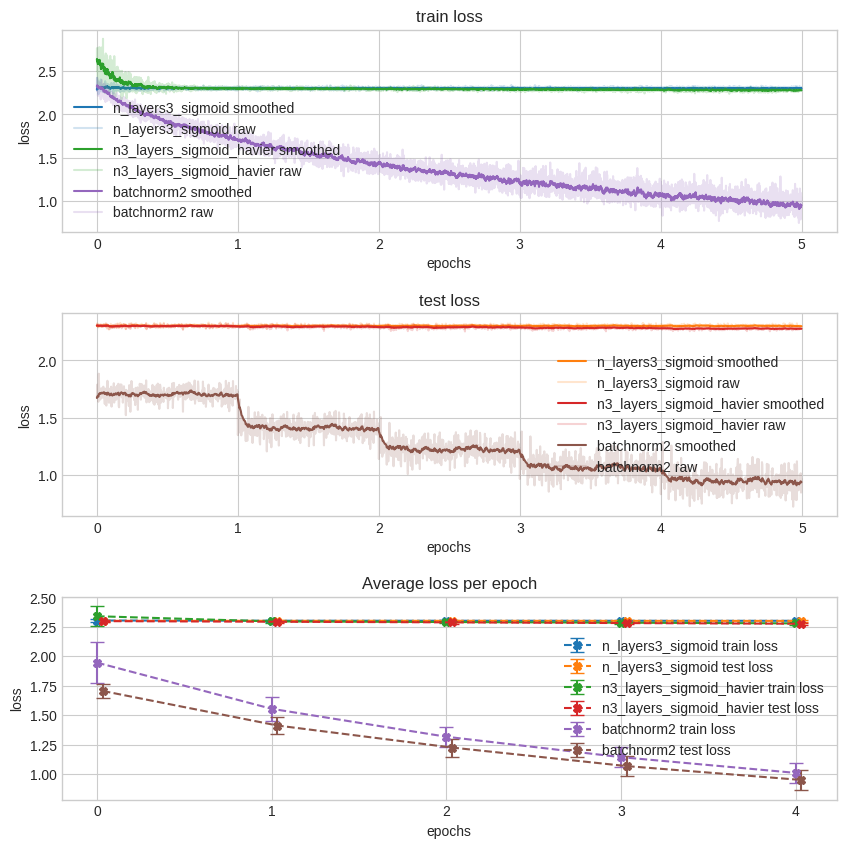

In [ ]:
history_plotter.add(history)
history_plotter.plot(["n_layers3_sigmoid", "n3_layers_sigmoid_havier", model_name])

Попробуем, согласно советам, увеличить learning rate:

In [ ]:
model_name = "batchnorm_increased_lr"
model = SimpleMNIST_NN_Batchnorm(n_layers=3)

trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name, optimizer_kwargs={"lr": 1e-2})

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                     | Params | Mode 
---------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Batchnorm | 100 K  | train
1 | criterion | CrossEntropyLoss         | 0      | train
---------------------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.400     Total estimated model params size (MB)
13        Modules in train mode
0         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
history_plotter.plot(["n3_layers_sigmoid_havier", "batchnorm2", model_name])

### Ставить Batch Normalization до или после активации?



#### До

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batchnormalization_before_activation.png" width="350"></center>

* **Рекомендуется авторами статьи, где предложили Batch Normalization**.
* Для **сигмоиды** BN, поставленная после активации, **не решает проблем** сигмоиды.
* Во многих сверточных архитектурах, например, [**ResNet** 🎓[arxiv]](https://arxiv.org/pdf/1512.03385.pdf) и [**MobileNetV2** 🎓[arxiv]](https://arxiv.org/pdf/1801.04381.pdf) (изучите на следующих лекциях), Batch Normalization ставится именно так.

#### После

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batchnormalization_after_activation.png" width="350"></center>

* **Аргументация авторов статьи не до конца обоснована**.
* Обычно **сигмоиду не используют** в современных нейронных сетях.
* Для популярной **ReLU BN**, поставленная до активации, может приводить в определённых случаях к “умирающей **ReLU**”, когда большая часть ее входов меньше $0$, и поэтому через них градиент не проходит.

**BN — before or after ReLU?**

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/batchnormalization_before_or_after_relu.png" width="500">

<em>Source: <a href="https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md">BN experiments</a></em></center>

**Вывод:** В общем случае стоит располагать слой BN перед активацией, но с этим можно экспериментировать.

## Другие Normalization

Существует большое количество иных нормализаций, их неполный список можно найти [здесь 🎓[article]](https://paperswithcode.com/methods/category/normalization). В данной секции мы рассмотрим самые популярные виды нормализации помимо **Batch Norm**.


Есть несколько мотиваций для замены батч-нормализации на другие типы нормализации:
- при обучении модели вы можете столкнуться с ситуацией, когда вам нужно учить модель при `batch_size=1` (больше не помещается на видеокарту). BN работает неэффективно с маленькими размерами батча,
- при параллельном обучении модели на нескольких видеокартах необходимо обмениваться статистиками для BN между устройствами. Обмен информацией между устройствами может замедлять обучение.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/normalization_methods.png" width="900">

<em>Source: <a href="https://paperswithcode.com/method/layer-normalization">Layer Normalization</a></em></center>

### Layer Norm

Помимо свёрточных нейронных сетей, существует специальный тип нейронных сетей, используемых для обработки последовательностей. Называется он "**рекуррентные нейронные сети**", ему будет посвящена одна из следующих лекций.

Когда оказалось, что **Batch Norm** положительно сказывается на обучении нейронных сетей, его попытались применить для различных архитектур. Batch Norm нельзя было использовать "из коробки" для рекуррентных нейронных сетей (работающих с последовательными данными), поэтому пришлось придумывать различные адаптации, среди которых наиболее удачной оказалась **Layer Normalization**.

По сути, теперь нормализация происходит внутри **одного объекта из батча**, а не поканально в рамках батча. С математической точки зрения данная "адаптация" отличается от **Batch Norm**, однако экспериментально она превзошла своих конкурентов в задаче нормализации при обработке последовательных данных.

Впоследствии данный метод нормализации хорошо проявил себя в **трансформерах** — наследниках рекуррентных нейронных сетей в вопросах обработки последовательных данных (об этом типе нейросетей мы также поговорим на одной из следующих лекций). После успешного применения трансформеров в задачах компьютерного зрения, **Layer Norm** стал использоваться и в компьютерном зрении.

Размер кубика:
$$[\text{batch size}, \text{channels}, \text{h}, \text{w}]$$

Статистики считаются по срезу:
$$[\text{batch size}, \text{ :}, \text{ :}, \text{ :}]$$

По одной статистике для кажого объекта в батче.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/visualization_of_layer_normalization.png" width="450">

<em>Source: <a href="https://paperswithcode.com/method/layer-normalization">Layer Normalization</a></em></center>


### Instance Norm

Следующий вид нормализации был предложен отечественными исследователями (из Сколтеха), занимавшимися разработкой быстрого и эффективного способа **переноса стиля** с одного изображения на другое.

При использовании Batch Norm теряется информация о контрастах на конкретном изображении, поскольку нормализация производится по нескольким объектам. Для сохранения *контрастов* в экземпляре (*instance*) изображения была предложена специальная нормализация, рассматривающая конкретный канал одного конкретного объекта. Было предложено два названия нормализации: связанное с мотивацией (contrast normalization) и связанное с принципом работы (**instance normalization**).

Размер кубика:
$$[\text{batch size}, \text{channels}, \text{h}, \text{w}]$$

Статистики считаются по срезу:
$$[\text{batch size}, \text{channels}, \text{ :}, \text{ :}]$$

По одной статистике для каждого канала каждого объекта в батче.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/visualization_of_instance_normalization.png" width="450"></center>

<center><em>Source: <a href="https://paperswithcode.com/method/instance-normalization">Instance Normalization</a></em></center>

### Group Norm

В течение долгого времени Batch Norm оставался однозначным фаворитом для использования в задачах компьютерного зрения, однако:
1. В связи с необходимостью точно считать статистики внутри batch при обучении приходилось использовать большой batch size.

2. Ограниченность размера памяти видеокарты вынуждает разработчиков идти на компромисс между сложностью модели и размером батча.

Таким образом, использование Batch Norm приводило к невозможности использовать сложные модели**\***, поскольку им просто не хватало места на видеокарте.

Необходимость использовать большой batch size могут решать различные нормализации, не использующие batch-размерность. К примеру, уже известные нам **Layer Norm** и **Instance Norm**. Эмпирически оказалось, что данные нормализации уступают Batch Norm по качеству работы: в то время как Layer Norm предполагает одинаковую важность и суть различных каналов (*рассматривая данные излишне глобально*), Instance Norm упускает межканальные взаимодействия (*рассматривая данные слишком локально*).

Успешным обобщением данных методов является **Group Normalization**: данный метод разбивает каналы на $G \in [1; C]$ групп, присваивая каждой из них примерно равное количество каналов. Отметим, что при $G = 1$ Group Norm идентичен Layer Norm, а при $G = C$ Group Norm идентичен Instance Norm.

Эмпирически оказалось, что при замене Batch Norm на Group Norm качество модели падает в разы менее значительно, чем при использовании Layer Norm либо Instance Norm. Более того, при изменении batch size качество работы Group Norm не изменялось, что открыло перспективы для создания более сложных моделей компьютерного зрения.

**\*** — подразумевается, что уменьшение batch size позволило бы создать более сложные модели.

Размер кубика:
$$[\text{batch size}, \text{channels}, \text{h}, \text{w}]$$

Статистики считаются по срезу:
$$[\text{batch size}, \text{ i: j}, \text{ :}, \text{ :}]$$

По одной статистике для каждой группы каналов каждого объекта в батче.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/visualization_of_group_normalization.png" width="450"></center>

<center><em>Source: <a href="https://paperswithcode.com/method/group-normalization">Group Normalization</a></em></center>

# Регуляризация

Второй способ улучшения сходимости нейросетей и борьбы с переобучением — введение регуляризации. Ее можно вводить несколькими способами.

## L1, L2 регуляризации

Мы уже разбирали самый простой способ — добавление штрафа к весам в функцию потерь. На сходимость нейросети это, правда, влияет слабо.

$$ \text{Loss_reg} = \text{loss} + \lambda \cdot \text{reg}$$

$$ \text{reg}_{L1} = \lambda \sum |w_i| $$

$$ \text{reg}_{L2} = \lambda \sum w_i^2 $$

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/loss_landscape_with_regularization.gif" width="800"></center>

<center><em>Source: <a href="https://people.eecs.berkeley.edu/~jrs/189/">Introduction to Machine Learning
</a></em></center>


Иногда уже этого хватает, чтобы решить все проблемы. Напомним, что **L2** Loss приводит к большому числу маленьких ненулевых весов в сети, а **L1** Loss — к маленькому числу ненулевых весов (разреженной нейросети).

В PyTorch L2-регуляризация (или её аналоги) часто "встроена" в оптимизаторы и связана с параметром `weight_decay`. Подробнее различия между `weight_decay` и L2 мы обсудим ниже.


```python
sgd = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0.001)
```



## Dropout

Одним из распространенных именно в нейросетях методом регуляризации является **Dropout**.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/dropout.png" width="700"></center>

Состоит этот метод в следующем:

1. Во время обучения мы с вероятностью $p$ **зануляем выход нейронов** слоя (например, $p = 0.5$).
2. Зануленные нейроны не участвуют в данном `forward`, и поэтому градиент к ним при `backward` не идет.
3. Сила регуляризации определяется вероятностью $p$: чем она больше, тем сильнее регуляризация.

###Сверточные слои

Аналогично **Batch Normalization**, при применении к **сверточному слою**  **Dropout** должен **убирать каналы целиком**. Dropout для полносвязного слоя реализован в PyTorch в `nn.Dropout` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html), для сверточного — в `nn.Dropout2d` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html).

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/dropout_2d.png" width="700"></center>

### Мотивация Dropout

#### Борьба с коадаптацией

Одной из  проблем при работе с глубокими сетями является **совместная адаптация нейронов**. Если все весовые коэффициенты обучаются вместе, некоторые соединения будут иметь больше возможностей прогнозирования, чем другие.

**Часть нейронов** делает основную работу — **предсказывает**, а остальные могут вообще не вносить никакого вклада в итоговое предсказание. Или же другая картина: один нейрон делает **неверное предсказание**, другие его **исправляют**, и в итоге первый нейрон свои ошибки не исправляет.

Можно попробовать понять, как это работает, через аналогию — конвейер по сборке машины: основную часть работы может исполнять небольшое количество работников. Другие работники могут лениться и передавать деталь, которая к ним поступила, без изменений или откручивать только что добавленные части. Если мы исключим “эффективных работников”, результат станет удручающим.

Это явление называется **коадаптацией**. Его нельзя было предотвратить с помощью традиционной регуляризации, такой как **L1** или **L2**. А вот **Dropout** с этим хорошо борется.

Отключая хорошо обученные нейроны, мы заставляем плохо обученные нейроны учиться. Отключая нейроны, которые исправляют ошибки других нейронов, мы заставляем ошибающиеся нейроны исправлять ошибки.

**Dropout** гарантирует, что выучиваемые индивидуальными нейронами функции хорошо работают со **случайно выбранными подмножествами функций**, выученных другими нейронами, улучшая **обобщающую способность** нейронов.

На следующем рисунке, извлеченном из [статьи про Dropout 🎓[article]](https://jmlr.org/papers/v15/srivastava14a.html), мы находим сравнение признаков, изученных в наборе данных **MNIST** нейросетью с **одним скрытым слоем** в автоэнкодере, имеющем $256$ признаков после ReLU **без Dropout** (слева), и признаков, изученных той же структурой с использованием **Dropout** в ее скрытом слое с $p = 0.5$ (справа).

Первый показывает неструктурированные, беспорядочные паттерны, которые невозможно интерпретировать. Второй явно демонстрирует целенаправленное распределение весов, которое обнаруживает штрихи, края и пятна самостоятельно, нарушая их взаимозависимость с другими нейронами для выполнения этой работы.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/compare_weights_with_dropout_and_without_dropout.png" width="600"></center>

<center><em>Source: <a href="https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf">Dropout: A Simple Way to Prevent Neural Networks from
Overfitting</a></em></center>

#### Dropout как регуляризация

Фактически **Dropout** штрафует слишком сложные, неустойчивые решения. Добавляя в нейросеть **Dropout**, мы сообщаем ей, что решение, которое мы ожидаем, должно быть устойчиво к шуму.

#### Dropout как ансамбль

Можно рассматривать **Dropout** как **ансамбль нейросетей** со схожими параметрами, которые мы учим одновременно вместо того, чтобы учить каждую в отдельности, а затем результат их предсказания усредняем, [выключая Dropout в режиме eval ✏️[blog]](https://habr.com/ru/companies/wunderfund/articles/330814/).

Таким образом возникает аналогия со случайным лесом: каждая из наших нейросетей легко выучивает выборку и переобучается — имеет низкий bias, но высокий variance. При этом, за счет временного отключения активаций, каждая нейросеть видит не все объекты, а только часть. Усредняя все эти предсказания, мы уменьшаем variance.

#### Dropout помогает бороться с переобучением

Dropout, в силу указанного выше, может хорошо помогать бороться с переобучением.

И в случае линейных слоев:

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/dropout_solve_overfitting_problem_in_mlp_networks.png" width="500">

<em>Source: <a href="https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/">Tutorial: Dropout as Regularization and Bayesian Approximation</a></em></center>

И в случае свёрточных слоёв:

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/dropout_solve_overfitting_problem_in_convolution_networks.png" width="500">

<em>Source: <a href="https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/">Tutorial: Dropout as Regularization and Bayesian Approximation</a></em></center>

#### Простая реализация Dropout

Напишем "наивную" реализацию модуля Dropout.

**Замечание:** этот блок кода дан для объяснения работы Dropout. При построении нейронной сети используйте `nn.Dropout` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) или `nn.Dropout2d` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html).

```python
class BadDropout(nn.Module):
    def __init__(self, p: float=0.5):
        super().__init__()
        if p < 0 or p > 1:
            raise ValueError(
                f"Dropout probability has to be between 0 and 1, but got {p}"
            )
        self.p = p

    def forward(self, x):
        if self.training:
            keep = torch.rand(x.size()) > self.p
            if x.is_cuda:
                keep = keep.to(device)
            return x * keep
        # In test time, expectation is calculated
        return x * (1 - self.p)
```



Приведенная реализация неоптимальна, так как в режиме инференса (когда `training = False`) функция `forward` совершает дополнительное умножение. Одним из приоритетов при создании модели является скорость работы в режиме инференса. Поэтому по возможности все "лишние" операции выполняют только в режиме обучения. В данном случае можно целиком убрать коэффициент нормировки из режима инференса, перенеся его в режим обучения в знаменатель.

Дополнительным плюсом такого подхода является то, что при удалении модуля из архитектуры сети функция прогнозирования не изменится.


```python
class Dropout(nn.Module):
    def __init__(self, p: float=0.2):
        super().__init__()
        if p < 0 or p > 1:
            raise ValueError(
                f"Dropout probability has to be between 0 and 1, but got {p}"
            )
        self.p = p

    def forward(self, x):
        if self.training:
            keep = torch.rand(x.size()) > self.p
            if x.is_cuda:
                keep = keep.to(x)
            return x * keep / (1 - self.p)
        return x  # in test time, expectation is calculated intrinsically - we just not divide weights
```



Попробуем применить Dropout в нашей нейросети:

In [ ]:
class SimpleMNIST_NN_Dropout(nn.Module):
    def __init__(self, n_layers, activation=nn.Sigmoid, init_form="normal"):
        super().__init__()
        self.n_layers = n_layers
        self.activation = activation()
        layers = [nn.Linear(28 * 28, 100), self.activation]
        for _ in range(0, n_layers - 1):
            layers.append(nn.Linear(100, 100))
            layers.append(nn.Dropout(p=0.2))  # add Dropout
            layers.append(self.activation)
        layers.append(nn.Linear(100, 10))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.layers(x)
        return x

Так как наша модель из-за Dropout ведет себя по-разному во время обучения и во время тестирования, мы должны прямо ей сообщать, обучается она сейчас или нет.

$$
\begin{array}{c|c}
\large{\text{model.train()}}&\ \large{\text{model.eval()}}\\  \hline
\large{\text{Активируются Dropout слои}}&\large{\text{Слои Dropout отключены}}\\
\large{\text{Выход части нейронов обнуляется, выходы нормируются}}&\large{\text{Все нейроны работают}}
\end{array}
$$



Обучим модель с **Dropout**:

In [ ]:
model_name = "nn3_dropout"
model = SimpleMNIST_NN_Dropout(n_layers=3)

trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(model=model, exp_name=model_name, optimizer_kwargs={"lr": 1e-2})

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Dropout | 99.7 K | train
1 | criterion | CrossEntropyLoss       | 0      | train
-------------------------------------------------------------
99.7 K    Trainable params
0         Non-trainable params
99.7 K    Total params
0.399     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mod

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


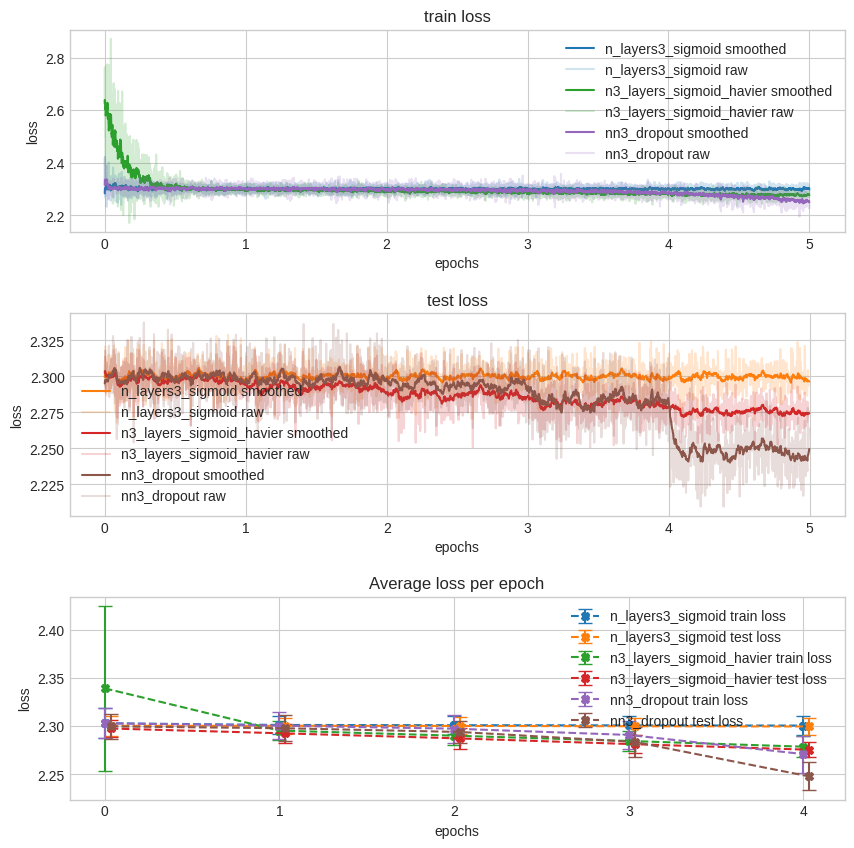

In [ ]:
history_plotter.plot(["n_layers3_sigmoid", "n3_layers_sigmoid_havier", model_name])

В данном случае выигрыш небольшой. Если учить нейросеть больше эпох, эффект будет заметнее.

#### Пример борьбы с переобучением при помощи Dropout


Чтобы увидеть эффект и при этом не учить нейросеть 100+ эпох, сделаем искусственный пример.

Просто **добавим к линейной зависимости шум** и попробуем выучить ее нейронной сетью.

[[colab] 🥨 Batch Normalization and Dropout](https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/7_BatchNormalization/BatchNorm_Dropout.ipynb)

In [ ]:
N = 50  # number of data points
noise = 0.3

# Generate the train data
x_train = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_train = x_train + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

# Generate the test data
x_test = torch.unsqueeze(torch.linspace(-1, 1, N), 1)
y_test = x_test + noise * torch.normal(torch.zeros(N, 1), torch.ones(N, 1))

print(f"x_train shape: {x_train.shape}\nx_test shape: {x_test.shape}")

x_train shape: torch.Size([50, 1])
x_test shape: torch.Size([50, 1])


In [ ]:
plt.scatter(
    x_train.data.numpy(), y_train.data.numpy(), c="purple", alpha=0.5, label="train"
)
plt.scatter(
    x_test.data.numpy(), y_test.data.numpy(), c="yellow", alpha=0.5, label="test"
)

x_real = np.arange(-1, 1, 0.01)
y_real = x_real
plt.plot(x_real, y_real, c="green", label="true")
plt.legend()
plt.show()

Модель **без Dropout**:

In [ ]:
N_h = 100  # num of neurons
model = torch.nn.Sequential(
    torch.nn.Linear(1, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Модель **с Dropout**:

In [ ]:
N_h = 100  # num of neurons

model_dropout = nn.Sequential(
    nn.Linear(1, N_h),
    nn.Dropout(0.5),  # 50 % probability
    nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    nn.Dropout(0.2),  # 20% probability
    nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)
optimizer_dropout = torch.optim.Adam(model_dropout.parameters(), lr=0.01)

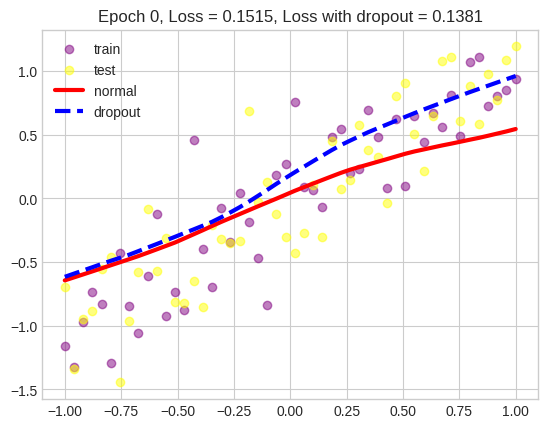

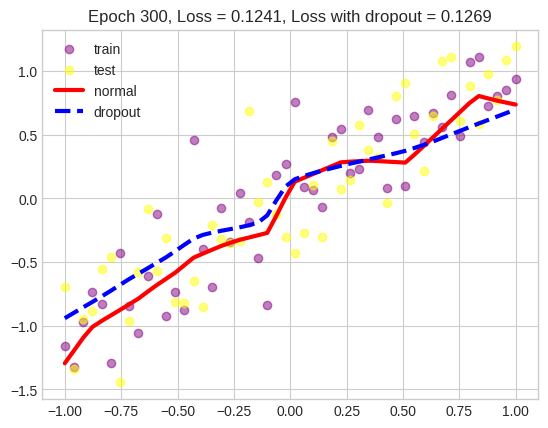

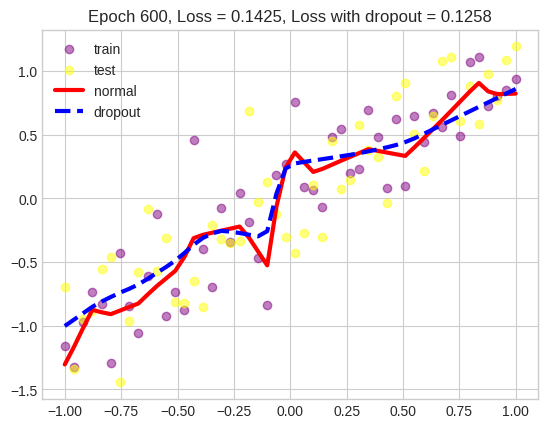

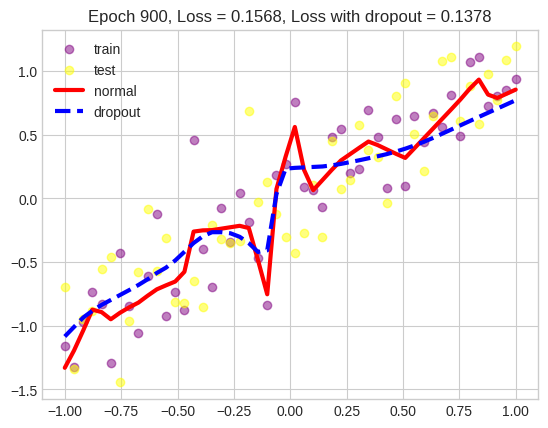

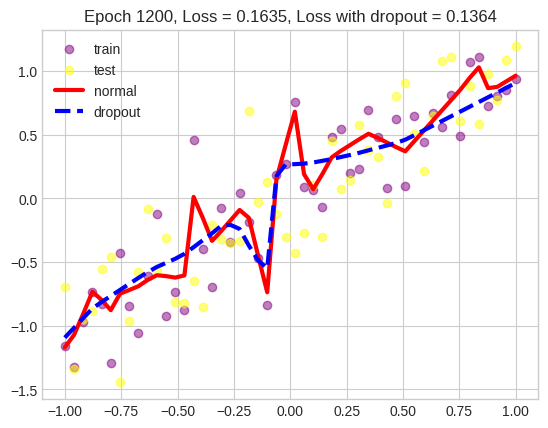

In [ ]:
num_epochs = 1500
criterion = torch.nn.MSELoss()

for epoch in range(num_epochs):

    # Train without dropout
    y_pred = model(x_train)  # look at the entire data in a single shot
    loss = criterion(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Train with dropout
    y_pred_dropout = model_dropout(x_train)
    loss_dropout = criterion(y_pred_dropout, y_train)
    optimizer_dropout.zero_grad()
    loss_dropout.backward()
    optimizer_dropout.step()

    if epoch % 300 == 0:
        model.eval()  # not train mode
        model_dropout.eval()  #  not train mode

        # Get predictions
        y_test_pred = model(x_test)
        test_loss = criterion(y_test_pred, y_test)

        y_test_pred_dropout = model_dropout(x_test)
        test_loss_dropout = criterion(y_test_pred_dropout, y_test)

        # Plotting data and predictions
        plt.scatter(
            x_train.data.numpy(),
            y_train.data.numpy(),
            c="purple",
            alpha=0.5,
            label="train",
        )
        plt.scatter(
            x_test.data.numpy(),
            y_test.data.numpy(),
            c="yellow",
            alpha=0.5,
            label="test",
        )
        plt.plot(
            x_test.data.numpy(), y_test_pred.data.numpy(), "r-", lw=3, label="normal"
        )
        plt.plot(
            x_test.data.numpy(),
            y_test_pred_dropout.data.numpy(),
            "b--",
            lw=3,
            label="dropout",
        )

        plt.title(
            "Epoch %d, Loss = %0.4f, Loss with dropout = %0.4f"
            % (epoch, test_loss, test_loss_dropout)
        )

        plt.legend()

        model.train()  # train mode
        model_dropout.train()  # train mode

        plt.pause(0.05)

Видим, что **нейросеть без Dropout сильно переобучилась**.

#### Доверительный интервал от Dropout

Dropout можно рассматривать как **ансамбль моделей**.

Если мы возьмем один и тот же объект и пропустим его через модель с **активным Dropout 1000 раз**, это будет эквивалентно тому, чтобы пропустить этот объект через **1000 моделей с различными конфигурациями**. Таким образом мы получим распределение предсказаний, на основе которого можно вычислять [**доверительные интервалы** 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%94%D0%BE%D0%B2%D0%B5%D1%80%D0%B8%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B9_%D0%B8%D0%BD%D1%82%D0%B5%D1%80%D0%B2%D0%B0%D0%BB) и ловить аномалии (объекты с большой дисперсией предсказываемых значений, которые плохо распознаются сетью).

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/confidence_interval_dropout.png" width="600"></center>

<center><em>Source: <a href="https://atcold.github.io/NYU-DLSP20/en/week14/14-3/">Overfitting and regularization</a></em></center>



## DropConnect

Если занулять не нейроны (активации), а случайные веса с вероятностью $p$, получится DropConnect.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/dropconnect.png" width="650"></center>

DropConnect похож на Dropout, поскольку он вводит динамическую разреженность в модель, но отличается тем, что разреженность зависит от весов *W*, а не от выходных векторов слоя. Другими словами, полностью связанный слой с DropConnect становится разреженно связанным слоем, в котором соединения выбираются случайным образом на этапе обучения.

В принципе, вариантов зануления чего-то в нейронной сети можно предложить великое множество, в разных ситуациях будут работать разные способы ([в этом списке 🎓[article]](https://paperswithcode.com/methods/category/regularization) много Drop...).

## DropBlock

Например, можно убирать для каждого батча из нейросети случайные блоки из слоев. И это будет работать!

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/dropblock.png" width="750"></center>

[[arxiv] 🎓 Deep Networks with Stochastic Depth (Huang et al., 2016)](https://arxiv.org/pdf/1603.09382.pdf)

## Batch Normalization до или после Dropout



### После

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batchnormalization_after_dropout.png" width="400"></center>

* **Плохо**: В режиме обучения **Dropout** будет отключать (занулять) выходы слоя активации, из-за этого накопленные в режиме обучения **значения скользящего среднего матожидания и дисперсии** для вычисления **Batch Normalization** в режиме тестирования будут иметь **сдвиг** (не компенсируемый приведением слоя Dropout в режим `train()`), который приведет к нестабильной работе нейросети.


Подробно:
* [[arxiv] 🎓 Understanding the Disharmony between Dropout and Batch Normalization by
Variance Shift (Li et al., 2018)](https://arxiv.org/pdf/1801.05134.pdf)
* [[git] 🐾 Understanding the Disharmony between Dropout and Batch Normalization](https://github.com/adelizer/kaggle-sandbox/blob/master/drafts/dropout_bn.ipynb)

### До

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/batchnormalization_before_dropout.png" width="400"></center>

* **Лучше**: Меньше влияние сдвига от **Dropout** на **Batch Norm**. Но если на предыдущих слоях есть **Dropout**, то значения все равно могут быть смещены.

### Ставить только что-то одно

* **Dropout** может отрицательно влиять на качество нейросети с **Batch Norm** за счет разного поведения на train и test. Лучше не ставить **Dropout** раньше **Batch Norm**.

# Оптимизация параметров нейросетей

В процессе обучения мы пытаемся подобрать параметры модели, при которых она будет работать лучше всего. Это **оптимизационная задача** (задача подбора оптимальных параметров). Мы уже ознакомились с одним алгоритмом оптимизации параметров — **градиентным спуском**.

Существует множество **алгоритмов оптимизации**, которые можно применять для поиска минимума функционала ошибки ([неполный список 🎓[article]](https://paperswithcode.com/methods/category/stochastic-optimization)). Эти алгоритмы реализованы в модуле `torch.optim` [🛠️[doc]](https://pytorch.org/docs/stable/optim.html).

Важно отметить, что **выбор оптимизатора не влияет на расчет градиента**. Градиент в PyTorch вычисляется автоматически на основе графа вычислений.


## Обзор популярных оптимизаторов

### SGD (stochastic gradient descent)

При градиентном спуске мы:
- делаем **прямой проход**, вычисляем функционал ошибки $\large L(x, y, w_t)$;
- делаем **обратный проход**, вычисляем градиент $\large \nabla_wL(x, y, w_t)$;
- делаем **шаг оптимизации**: изменяем параметры модели по формуле:

$$\large w_{t+1} = w_t - \text{lr} \cdot \nabla_wL(x, y, w_t),$$

домножая антиградиент на постоянный коэффициент $\text{lr}$ (гиперпараметр обучения — learning rate).

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/stochastic_gradient_descent.gif" width="950">

У данного алгоритма есть проблема: он может застревать в **локальных минимумах** или даже **седловых точках**.

**Cедловые точки** — точки, в которых все производные равны $0$, но они не являются экстремумами. В них градиент равен $0$, веса не обновляются — оптимизация останавливается.

Пример таких точек:

- точка $(0, 0)$ у функции $y = x^3$, не имеющей минимума или максимума вовсе;
- точка $(0, 0, 0)$ у функции $z = x^2 - y^2$.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/getting_stuck_in_local_minimum_example.png" width="350"> <img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/saddle_point_example.png" width="400"></center>

<center><em>Source: <a href="https://ru.wikipedia.org/wiki/%D0%A1%D0%B5%D0%B4%D0%BB%D0%BE%D0%B2%D0%B0%D1%8F_%D1%82%D0%BE%D1%87%D0%BA%D0%B0">Седловая точка</a></em></center>

Частично эту проблему решает **стохастический градиентный спуск** (stochastic gradient descent, **SGD**). В нем для градиентного спуска используются не все данные, а некоторая подвыборка (mini-batch) или даже один элемент.


**SGD** обладает важной особенностью: на каждом объекте или подвыборке (mini-batch) ландшафт функции потерь выглядит по-разному. Некоторые минимумы функции потерь и седловые точки могут быть характерны лишь для части объектов.

Ниже **упрощенно** показаны ландшафты функции потерь на полном датасете и на отдельных батчах. При оптимизации на полном датасете модель могла бы **остановиться в левом локальном минимуме**, но стохастическая природа спуска позволяет избежать этого за счет того, что **для некоторых батчей этот минимум отсутствует**.

В результате модель сможет остановиться только в каком-то относительно широком и глубоком минимуме, характерном для большинства батчей обучающих данных. С большой вероятностью этот минимум будет присутствовать и на реальных данных, то есть модель сможет адекватно работать с ними.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/sgd_loss_batch_landscape.png" width="700"></center>

**SGD** до сих пор является достаточно популярным методом обучения нейросетей, потому что он простой, не требует подбора дополнительных гиперпараметров, кроме **скорости обучения** `lr`, и сам по себе обычно дает неплохие результаты.

Если же модель учится слишком долго и/или важна каждая сотая в качестве, то нужно либо использовать его в совокупности с другими техниками (их рассмотрим далее), либо использовать другие способы.

Фрагмент кода для понимания работы SGD:

```python
class SGD:
  def __init__(self, parameters, lr):
    self.parameters = parameters
    self.lr = lr

  def step(self):
    d_parameters = self.parameters.grad
    self.parameters -= self.lr*d_parameters
```

Алгоритм SGD реализован в `torch.optim.SGD` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html):

In [ ]:
import torch.optim as optim

parameters = torch.randn(10, requires_grad=True)
optimizer = optim.SGD(model.parameters(), lr=0.001)

**Минусы SGD**:

 1. Если функция ошибки в одном направлении меняется быстро, а в другом — медленно, то это приводит к резким изменениям направления градиентов и замедляет процесс обучения.


<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/stohastic_gradient_descent_no_momentum.gif" width="500"></center>


2. Может застревать в локальных минимумах или седловых точках.
3. Мы оцениваем градиент по малым частям выборки, которые могут плохо отображать градиент по всей выборке и являться шумными. В результате часть шагов градиентного спуска делается впустую или во вред.
4. Мы применяем один и тот же `learning rate` ко всем параметрам, что не всегда разумно. Параметр, отвечающий редкому классу, будет обучаться медленнее остальных.
5. Просто медленнее сходится.

**SGD** является основой всех описанных ниже алгоритмов.

### Momentum

Чтобы избежать проблем 1–3, можно добавить движению по ландшафту функции ошибок инерцию (**momentum**). По аналогии с реальной жизнью: если мяч катится с горки, то он благодаря инерции может проскочить пологое место или даже небольшую яму.

Корректируем направление движения шарика с учетом текущего градиента:

$$\large v_{t} = m \cdot v_{t-1} + \nabla_wL(x, y, w_{t}),$$

где $m \in [0, 1)$ — momentum (гиперпараметр).

Вычисляем, куда он покатится:

$$\large w_{t+1} = w_t - \text{lr} \cdot v_{t}$$

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/advantages_wtih_momentum.png" width="480"></center>

[[video] 📺 Градиентный спуск, как обучаются нейронные сети](https://youtu.be/IHZwWFHWa-w)

Теперь мы быстрее достигаем локального минимума и можем выкатываться из совсем неглубоких. Градиент стал менее подвержен шуму, меньше осциллирует.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/stohastic_gradient_descent_no_momentum.gif" width="500"> <img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/stohastic_gradient_descent_with_momentum.gif" width="500">

Фрагмент кода для понимания работы Momentum:

```python
class SGD_with_momentum:
  def __init__(self, parameters, momentum, lr):
    self.parameters = parameters
    self.momentum = momentum
    self.lr = lr
    self.velocity = torch.zeros_like(parameters)

  def step(self):
    d_parameters = self.parameters.grad
    self.velocity =  self.momentum*self.velocity + d_parameters
    self.weights -= self.lr*self.velocity
```


**Momentum удваивает количество хранимых параметров.**

Алгоритм Momentum реализован в `torch.optim.SGD` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html):

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=0.001)

У этого подхода есть одна опасность — мы можем выкатиться за пределы минимума, к которому стремимся, а потом какое-то время к нему возвращаться.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/problem_of_big_momentum_value.gif" width="700">

<em>Source: <a href="https://distill.pub/2017/momentum/">Why Momentum Really Works</a></em></center>

[[demo] 🎮 Why Momentum Really Works](https://distill.pub/2017/momentum/)

Чтобы с этим бороться, предложен другой способ подсчета инерции.

### NAG (Nesterov momentum)

Будем сначала смещаться в сторону, куда привел бы нас накопленный градиент, там считать новый градиент и смещаться по нему.
В результате перескоки через минимум будут менее значительными и алгоритм будет быстрее сходиться:

$$\large v_{t} = m \cdot v_{t-1} +  \nabla_w L(w_t - \text{lr} \cdot m \cdot  v_{t-1} )$$

$$\large w_{t+1} = w_{t} - \text{lr} \cdot v_{t} $$

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/nesterov_momentum.png" width="800"></center>

Кажется, что для реализации такого алгоритма необходимо пересчитывать прямой и обратный проход с новыми параметрами для вычисления градиента. На практике эту формулу можно [переписать 🎓[article]](http://www.cs.toronto.edu/~hinton/absps/momentum.pdf) так, чтобы не пересчитывать градиент.

С псевдокодом, описывающим последовательность действий NAG, можно познакомиться в [PyTorch 🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html).

**Так же, как momentum, Nesterov momentum удваивает количество хранимых параметров.**

Алгоритм Nesterov momentum реализован в `torch.optim.SGD` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html):

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.SGD(model.parameters(), momentum=0.9, nesterov=True, lr=0.001)

### Adaptive Learning Rate

Описанные алгоритмы не борются с 4-ой проблемой SGD: "мы применяем **один и тот же learning rate ко всем параметрам**, что не всегда разумно. Параметр, отвечающий редкому классу, будет обучаться медленнее остальных".

**Пример:** мы решаем задачу классификации картинок из Интернета, и у нас есть параметры, ответственные за признаки, которые характеризуют кошек породы сфинкс. Кошки породы сфинкс встречаются в нашем датасете редко, и эти параметры реже получают информацию для обновления. Поэтому наша модель может хуже классифицировать кошек этой породы.

Для решения этой проблемы мы можем завести для каждого параметра **индивидуальный learning rate**, зависящий от того, как часто и как сильно изменяется этот параметр в процессе обучения.

### Adagrad

Будем хранить для каждого параметра **сумму квадратов его градиентов** (запоминаем, как часто и как сильно он изменялся).

И будем вычитать из значений параметров градиент с коэффициентом, обратно пропорциональным корню из этой суммы $G_t$.

$$\large G_ t = \sum_{i=1}^t \nabla_w L(x,y,w_i)\odot\nabla_w L(x,y,w_i), $$

$$\large w_{t+1} = w_{t} -  \frac{\text{lr}}{\sqrt{G_t} + e} \odot \nabla_w L(x,y,w_{t}), $$

где $e$ — малая константа, чтобы не допускать деления на ноль, $\odot$ — поэлементное умножение.

В результате, если градиент у нашего веса часто большой, коэффициент будет уменьшаться.

Проблема заключается в том, что при такой формуле learning rate неминуемо в конце концов затухает (так как сумма квадратов не убывает).


Фрагмент кода для понимания работы Adagrad:

```python
class AdaGrad:
  def __init__(self, parameters, lr=0.01):
     self.parameters = parameters
     self.lr = lr
     self.grad_squared = torch.zeros_like(parameters)

  def step(self):
    d_parameters = self.parameters.grad
    self.grad_squared += d_parameters*d_parameters
    self.parameters -= self.lr*d_parameters / (torch.sqrt(self.grad_squared) + 1e-7)
```



**Adagrad удваивает количество хранимых параметров.**

Алгоритм Adagrad реализован в `torch.optim.Adagrad` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html):

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.Adagrad(model.parameters(), lr=0.01)

### RMSprop

Добавим "забывание" предыдущих квадратов градиентов. Теперь мы считаем не сумму квадратов, а [экспоненциальное скользящее среднее 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%A1%D0%BA%D0%BE%D0%BB%D1%8C%D0%B7%D1%8F%D1%89%D0%B0%D1%8F_%D1%81%D1%80%D0%B5%D0%B4%D0%BD%D1%8F%D1%8F) с коэффициентом $\alpha$.


$$\large G_t = \alpha \cdot G_{t-1} + (1-\alpha) \cdot \nabla_w L(x,y,w_t) \odot \nabla_w L(x,y,w_t)$$

$$\large w_{t+1} = w_{t} - \frac{\text{lr}}{\sqrt{G_t }+ e} \odot \nabla_w L(x,y,w_t)$$

Фрагмент кода для понимания работы RMSprop (Root Mean Square Propagation):

```python
class RMSprop():
  def __init__(self, parameters, lr=0.01, alpha=0.99):
    self.parameters = parameters
    self.lr = lr
    self.alpha = alpha
    self.grad_squared = torch.zeros_like(parameters)

  def step(self):
    d_parameters = self.parameters.grad
    self.grad_squared = self.alpha*self.grad_squared + \
        (1 - self.alpha)*d_parameters*d_parameters

    self.parameters -= self.lr*d_parameters / (torch.sqrt(self.grad_squared) + 1e-7)
```



**Так же, как Adagrad, RMSprop удваивает количество хранимых параметров.**

Алгоритм RMSprop реализован в `torch.optim.RMSprop` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html):

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99)

### Adam

Одним из самых популярных адаптивных оптимизаторов является Adam, объединяющий идеи Momentum и Adaptive learning rate:

$$\large v_t = \beta_1 \cdot v_{t-1} + (1-\beta_1) \cdot \nabla_w L(x,y,w_t),$$

$$\large G_t = \beta_2 \cdot G_{t-1} + (1-\beta_2) \cdot \nabla_w L(x,y,w_t) \odot \nabla_w L(x,y,w_t),$$

$$\large w_{t+1} = w_t - \frac{\text{lr}}{\sqrt{G_t} + e} \odot v_t,$$

где $\beta_1$ — аналог $m$ из Momentum, а $\beta_2$ — аналог $\alpha$ из RMSprop.

Фрагмент кода для понимания работы Adam:

```python
class Adam:
  def __init__(self, parameters, lr=0.01, betas=(0.9, 0.999)):
    self.parameters = parameters
    self.lr = lr
    self.betas = betas
    self.velocity = torch.zeros_like(parameters)
    self.grad_squared = torch.zeros_like(parameters)
    self.beta_1 = betas[0] # momentum
    self.beta_2 = betas[1] # alpha

  def step(self):
    d_parameters = self.parameters.grad
    # Momentum
    self.velocity = self.beta_1*self.velocity + (1 - self.beta_1)*d_parameters
    # Adaptive learning rate
    self.grad_squared = self.beta_2*self.grad_squared + \
        (1 - self.beta_2)*d_parameters*d_parameters
    self.parameters -= self.lr*self.velocity / (torch.sqrt(self.grad_squared) + 1e-7)
```



**Adam утраивает количество хранимых параметров.**

Чтобы в начале у нас получались очень большие шаги, будем дополнительно модицифировать инерцию и сумму квадратов:

$$\large v_t = \frac{v_t}{1-\beta_1^t}, \qquad G_t = \frac{G_t}{1-\beta_2^t} $$

Алгоритм Adam реализован в `torch.optim.Adam` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html):

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.Adam([parameters], betas=(0.9, 0.999))

Пример применения:

In [ ]:
model_name = "adam"
model = SimpleMNIST_NN_Batchnorm(n_layers=3)

trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(
    model=model,
    exp_name=model_name,
    optimizer_class=torch.optim.Adam,
    optimizer_kwargs={"lr": 1e-2},
)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                     | Params | Mode 
---------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Batchnorm | 100 K  | train
1 | criterion | CrossEntropyLoss         | 0      | train
---------------------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.400     Total estimated model params size (MB)
13        Modules in train mode
0         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


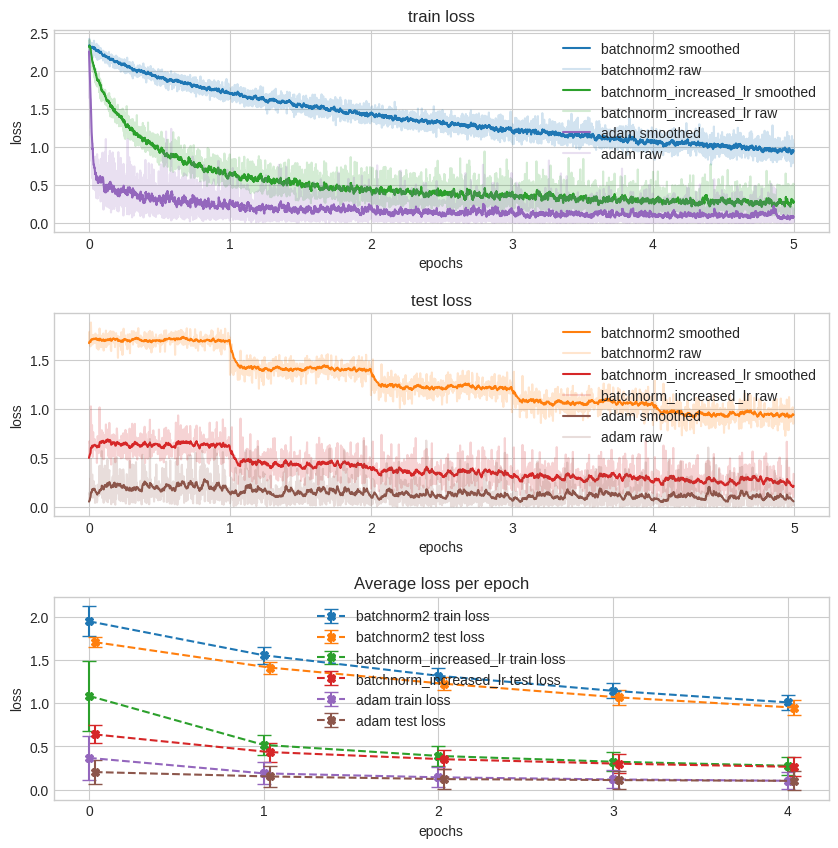

In [ ]:
history_plotter.plot(["batchnorm2", "batchnorm_increased_lr", model_name])

### L2 vs Weight decay

Для использования L2 c оптимизатором необходимо указать значение `weight_decay`,  где `weight_decay` — коэффициент перед L2.

In [ ]:
parameters = torch.randn(10, requires_grad=True)
optimizer = optim.RMSprop([parameters], alpha=0.99, weight_decay=0.001)

Вообще говоря, **Weight decay** и **L2** — это немного разные вещи.

**L2** добавляет член регуляризации к Loss функции:

$$\text{Loss}_{L2} = \text{Loss} + \frac{λ}{2n}w^2$$

**Weight decay** уменьшает веса:

$$w_{wd} = w - \frac{λ}{n}w$$

где $λ$ — константа, а $n$ — количество элементов в батче.


Для **SGD** оптимизатора **Weight decay** и **L2** **эквивалентны**, но не для всех оптимизаторов это так.

Например, это не так для **Adam**. **L2**-регуляризация прибавляется к Loss функции и изменяет **значение градиента**, квадраты которого будут храниться. **Weight decay** изменяет только веса. Подробно об этом можно почитать в:

[[arxiv] 🎓 Decoupled Weight Decay Regularization (Loshchilov, Hutter, 2019)](https://arxiv.org/pdf/1711.05101.pdf)

**Обратите внимание**, что `weight_decay` в `torch.optim.Adam` — это **коэффициент перед L2**. **Weight decay** для **Adam** реализовано в
`torch.optim.AdamW`.


### Другие оптимизаторы (Lion)

Не Adam-ом единым живут нейронные сети. Есть альтернативные методы оптимизации, например, проект [Google Brain ✏️[blog]](https://research.google/teams/brain/) в 2023 году опубликовал [статью 🎓[arxiv]](https://arxiv.org/pdf/2302.06675.pdf), в которой описывает найденный в процессе [AutoML 🎓[arxiv]](https://arxiv.org/pdf/2101.08809.pdf) (автоматического подбора архитектур и алгоритмов) оптимизатор, названный **Lion**  (Evo**L**ved S**i**gn M**o**me**n**tum) 🦁.

Интересно, что AutoML алгоритм пришел к интуитивно понятной эвристике: градиенты — вещь не очень надежная. Они могут взрываться и затухать. Может, тогда мы зафиксируем размер шага, а градиенты будем использовать только для определения направления?

Для определения направления используют функцию $\text{sign}$ (знак):

\begin{align}
\text{sign}(x) = \left\{
\begin{array}{cl}
1 & x > 0 \\
0 & x = 0\\
-1 & x < 0.
\end{array}
\right.
\end{align}


К этому добавляется уже изученный нами momentum, чтобы знак “прыгал” реже. Интересно, что AutoML подобрал алгоритм, в котором используются две константы для momentum. $\beta_1$ — для определения текущего знака градиента, $\beta_2$ — для хранения значения $v_t$. Значения по умолчанию $\beta_1 = 0.9$, $\beta_2 = 0.99$. Это значит, что текущее значение градиента сильнее влияет на значение для выбора направления текущего шага $c_{t}$, чем на хранимое значение момента $v_t$.


Значение для вычисления направления текущего шага:

$$c_{t} = \beta_1 \cdot v_{t-1} + (1-\beta_1) \nabla_wL(x, y, w_{t})$$

Шаг оптимизатора. $λ$ — константа weight decay:

$$w_{t+1} = w_t - \text{lr} \cdot (\text{sign}(c_t) +λ w_t)$$

Обновление хранимого значения момента:

$$v_t = \beta_2 \cdot v_{t-1} + (1-\beta_2) \nabla_wL(x, y, w_{t})$$

Фрагмент кода для понимания работы **Lion**:

```python
class Lion:
  def __init__(self, parameters, lr=0.0001, betas=(0.9, 0.99), weight_decay=0.01):
    self.parameters = parameters
    self.lr = lr
    self.betas = betas
    self.velocity = torch.zeros_like(parameters)
    self.beta_1 = betas[0] # momentum 1
    self.beta_2 = betas[1] # momentum 2
    self.weight_decay = weight_decay

  def step(self):
    d_parameters = self.parameters.grad
    # current momentum
    current = self.beta_1*self.velocity + (1 - self.beta_1)*d_parameters
    # step
    self.parameters -= self.lr*(torch.sign(carent)+self.weight_decay*self.parameters)
    # history momentum
    self.velocity = self.beta_2*self.velocity + (1 - self.beta_2)*d_parameters
```

**Lion удваивает количество хранимых параметров.**

Обратите внимание, что значение `lr` по умолчанию у **Lion** выбрано меньше, чем у **Adam**. Это связано с тем, что только `lr` и регуляризация определяют размер шага. Авторы статьи советуют брать для **Lion** в 10 раз меньший `lr`, чем для **Adam**.

У **Lion** есть преимущества по сравнению с **Adam** и **AdamW**: в нем нет необходимости хранить квадраты градиентов. Он позволяет **снизить количество хранимых параметров** в 1.5–2 раза по сравнению с **AdamW**, а также сокращает количество операций, что позволяет [ускорить расчеты на 2–15% 🎓[arxiv]](https://arxiv.org/pdf/2302.06675.pdf) (в Colab это незаметно из-за специфики, связанной с виртуальными машинами).

Кроме того, **Lion** [позволяет добиться лучших результатов 🐾[git]](https://github.com/google/automl/tree/master/lion), чем AdamW, при обучении больших сложных моделей, таких как Visual Transformer-ы и диффузионные модели.

Но до сложных моделей мы пока не добрались, попробуем простую. Воспользуемся реализацией [Lion-Pytorch 🐾[git]](https://github.com/lucidrains/lion-pytorch):

In [ ]:
!pip install -q lion-pytorch

In [ ]:
from lion_pytorch import Lion

model_name = "lion"
model = SimpleMNIST_NN_Batchnorm(n_layers=3)

trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = Pipeline(
    model=model,
    exp_name=model_name,
    optimizer_class=Lion,
    optimizer_kwargs={"lr": 1e-4, "weight_decay": 1e-3},
)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                     | Params | Mode 
---------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Batchnorm | 100 K  | train
1 | criterion | CrossEntropyLoss         | 0      | train
---------------------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.400     Total estimated model params size (MB)
13        Modules in train mode
0         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


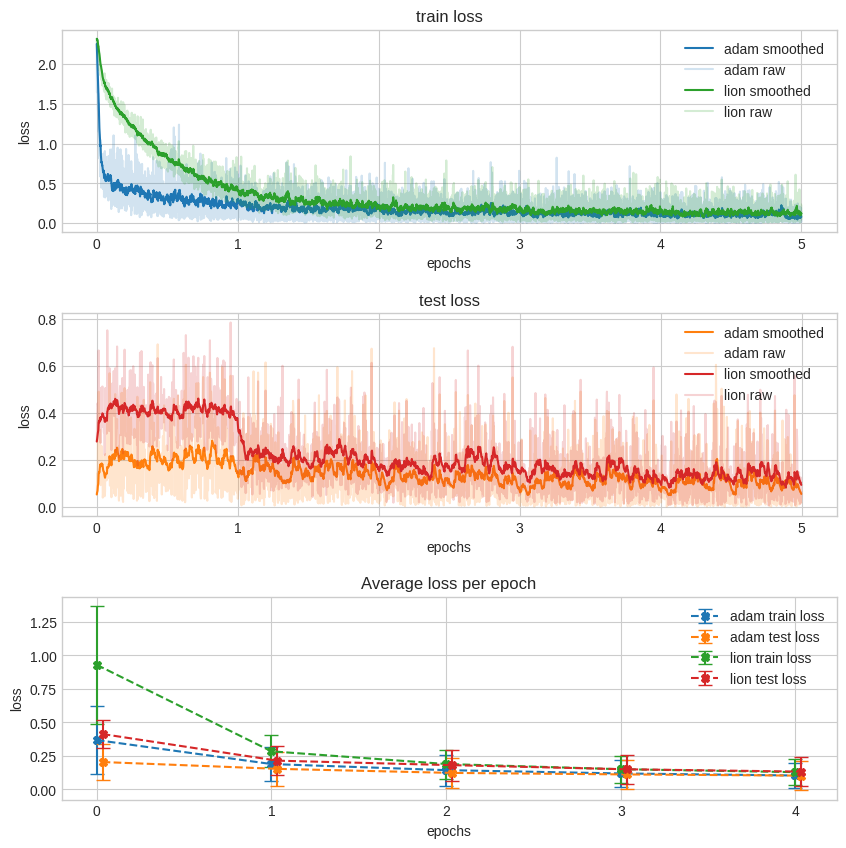

In [ ]:
history_plotter.plot(["adam", model_name])

Результат получился почти как у **Adam**, число хранимых параметров меньше. Для лучшего качества с Lion рекомендуется использовать `lr_scheduler`, чтобы постепенно понижать скорость обучения.



## Ландшафт функции потерь


Существует [исследование 🎓[article]](https://proceedings.neurips.cc/paper/2018/file/be3087e74e9100d4bc4c6268cdbe8456-Paper.pdf), которое показывает, что ландшафт функции потерь представляет собой не изолированные локальные минимумы (рисунок слева), а связанные области с почти постоянным значением (рисунок справа). Поэтому умение “выбираться” из седловых точек важно.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/loss_surfaces.png" width="900"></center>

<center><em>Source: <a href="https://proceedings.neurips.cc/paper/2018/file/be3087e74e9100d4bc4c6268cdbe8456-Paper.pdf">Loss Surfaces, Mode Connectivity, and Fast Ensembling of DNNs</a></em></center>

## Сравнение оптимизаторов

У каждого из предложенных оптимизаторов есть минусы и плюсы:

* Методы с инерцией сходятся к решению более плавно, но могут "перелетать".
* Методы с адаптивным learning rate быстрее сходятся, более стабильны и меньше случайно блуждают.
* Алгоритмы без адаптивного learning rate сложнее выбираются из локальных минимумов.
* Алгоритмы с инерцией осцилируют в седловых точках прежде, чем находят верный путь.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/methods_without_adaptive_learning_rate.gif" width="450"><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/methods_with_momentum_in_saddle_point.gif" width="450">

<em>Source: <a href="https://imgur.com/a/Hqolp">Visualizing Optimization Algos</a></em></center>

# Режимы обучения

Нам не обязательно поддерживать один и тот же `learning rate` в течение всего обучения. Более того, для того же SGD есть гарантии, что если правильно подобрать схему уменьшения `learning rate`, то он сойдется к глобальному оптимуму.

Мы можем менять `learning rate` по некоторым правилам.

## Ранняя остановка

Иногда мы можем сталкиваться с переобучением сети — появлением момента, когда качество на валидационной выборке начинает падать. Для того, чтобы бороться с этим, можно использовать раннюю остановку — прекращение обучения модели, когда ошибка на валидации начала расти.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/early_stopping.png" width="500"></center>

В Lightning для ранней остановки реализован callback `EarlyStopping` [🛠️[doc]](https://lightning-ai.webpkgcache.com/doc/-/s/lightning.ai/docs/pytorch/stable//common/early_stopping.html):

```python
from lightning.pytorch.callbacks.early_stopping import EarlyStopping


class LitModel(LightningModule):
    def validation_step(self, batch, batch_idx):
        loss = ...
        self.log("val_loss", loss)


model = LitModel()
trainer = Trainer(callbacks=[EarlyStopping(monitor="val_loss", mode="min")])
trainer.fit(model)
```



 Также хорошая практика — сохранение лучшей модели ([шпаргалка 🥨[colab]](https://colab.research.google.com/drive/16Q_k7NR4oGMh5CrqErsdzWwpihlK4lbH#scrollTo=-M1H2Y1DChmt)).

## Уменьшение скорости обучения на плато

Еще одним методом улучшения качества обучения является уменьшение скорости обучения на плато: когда значение функции потерь на валидационной выборке не улучшается какое-то количество эпох (`patience`), умножаем `learning rate` на некоторое значение `factor` < 1).

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/out/resnet_18_and_34_layers.png"  width="700"></center>
<center><em>График изменения ошибки при обучении двух модификаций ResNet с 34 и 18 слоями соответственно</em></center>

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", factor=0.1, patience=5
)

Применим к нашей модели (выполнение занимает ~ 5 минут).

Реализуем ниже код для обучения модели на чистом PyTorch, чтобы разобраться с тем, как именно планировщик обучения встроен в алгоритм обучения.
Отказавшись временно от Lightning, мы должны будем явно перемещать объекты между CPU и GPU, а также следить за тем, что мы верно выбрали режим работы `model.train()` или `model.eval()`.

In [ ]:
# Compute on cpu or gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def validate(model, criterion, val_loader):
    cumloss = 0
    loss_history = []
    with torch.no_grad():
        for batch in val_loader:
            x_train, y_train = batch  # parse data
            x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
            y_pred = model(x_train)  # get predictions
            loss = criterion(y_pred, y_train)  # compute loss
            loss_history.append(loss.cpu().detach().item())  # write loss to log
            cumloss += loss
    return cumloss / len(val_loader), loss_history  # mean loss and history


def train_epoch(model, optimizer, criterion, train_loader):
    loss_history = []
    for batch in train_loader:
        optimizer.zero_grad()
        x_train, y_train = batch  # parse data
        x_train, y_train = x_train.to(device), y_train.to(device)  # compute on gpu
        y_pred = model(x_train)  # get predictions
        loss = criterion(y_pred, y_train)  # compute loss
        loss_history.append(loss.cpu().detach().item())  # write loss to log
        loss.backward()
        optimizer.step()
    return loss_history

In [ ]:
from tqdm.notebook import tqdm


def train_model_sep_scheduler(
    model, optimizer, scheduler, model_name=None, num_epochs=5
):
    criterion = nn.CrossEntropyLoss().to(device)

    train_history = {}
    train_history["model_name"] = model_name
    train_history["epoсhs"] = num_epochs
    train_history["loss_on_train"] = []
    train_history["loss_on_test"] = []

    for epoch in tqdm(range(num_epochs)):
        model.train()
        loss_on_train = train_epoch(model, optimizer, criterion, train_loader)
        model.eval()
        val_loss, loss_on_test = validate(model, criterion, val_loader)
        train_history["loss_on_train"].extend(loss_on_train)
        train_history["loss_on_test"].extend(loss_on_test)
        scheduler.step(val_loss)
    return train_history

In [ ]:
model = SimpleMNIST_NN_Batchnorm(n_layers=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, "min", factor=0.1, patience=1
)

model_name = "reduce_lr_on_plateu"

history = train_model_sep_scheduler(
    model, optimizer, scheduler, model_name=model_name, num_epochs=5
)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
history_plotter.add(history)
history_plotter.plot([model_name])

Для реализации работы планировщика обучения `ReduceLROnPlateau` в рамках PyTorch Lightning нам достаточно переопределить метод `configure_optimizers` и указать, за значением какой логируемой переменной необходимо "следить" во время обучения. Вся остальная логика будет выполнена Lightning автоматически.

In [ ]:
class PipelineWithScheduler(Pipeline):
    def configure_optimizers(self):
        optimizer = self.optimizer_class(
            self.model.parameters(), **self.optimizer_kwargs
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=optimizer,
            min_lr=1e-9,
            factor=0.1,
            mode="min",
        )

        lr_scheduler = {
            "scheduler": scheduler,
            "interval": "epoch",
            "monitor": "loss_on_test",
        }
        return [optimizer], [lr_scheduler]

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.log("loss_on_test", loss, prog_bar=True)

        # Aux logging for lecture visualization
        self.history["loss_on_test"].append(loss.cpu().detach().item())
        return {"loss_on_test", loss}

In [ ]:
model_name = "reduce_lr_on_plateu_lightning"
model = SimpleMNIST_NN_Batchnorm(n_layers=3)

trainer = L.Trainer(
    max_epochs=5,
    logger=TensorBoardLogger(save_dir=f"logs/{model_name}"),
    num_sanity_val_steps=0,
)

pipeline = PipelineWithScheduler(
    model=model,
    exp_name=model_name,
    optimizer_class=torch.optim.Adam,
    optimizer_kwargs={
        "lr": 1e-2,
    },
)

trainer.fit(model=pipeline, train_dataloaders=train_loader, val_dataloaders=val_loader)

history = pipeline.history
history["epoсhs"] = trainer.max_epochs
history_plotter.add(history)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type                     | Params | Mode 
---------------------------------------------------------------
0 | model     | SimpleMNIST_NN_Batchnorm | 100 K  | train
1 | criterion | CrossEntropyLoss         | 0      | train
---------------------------------------------------------------
100 K     Trainable params
0         Non-trainable params
100 K     Total params
0.400     Total estimated model params size (MB)
13        Modules in train mode
0         Modules i

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


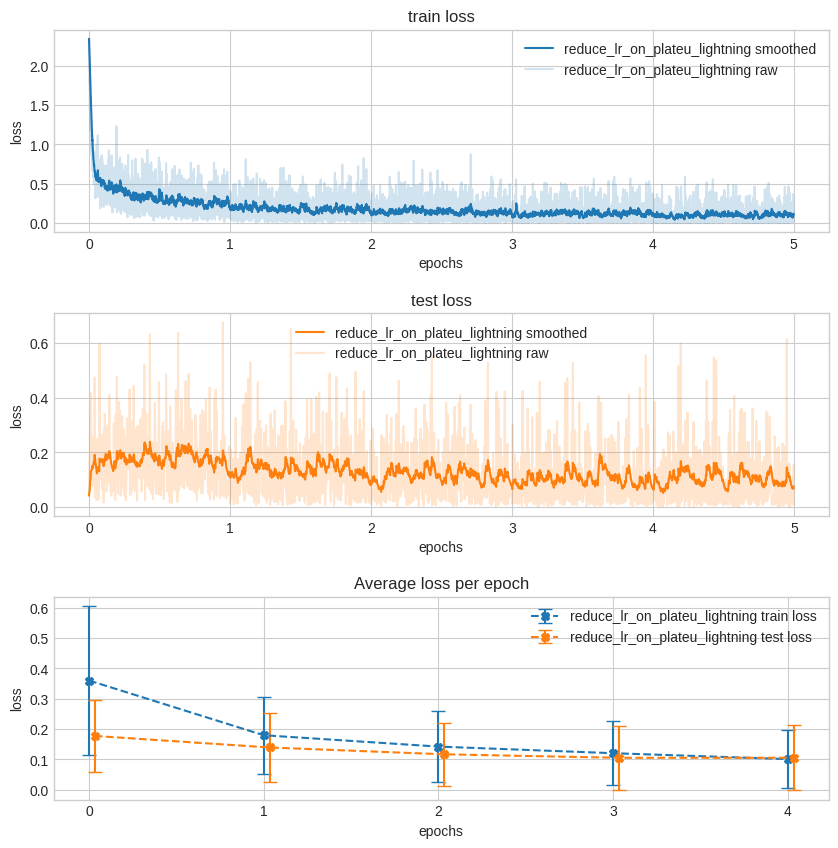

In [ ]:
history_plotter.plot([model_name])

## Понижение скорости обучения на каждой эпохе

Домножать `learning rate` на `gamma` каждую эпоху:

In [ ]:
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

## Neural Network WarmUp

Для достаточно больших нейронных сетей практикуют следующую схему ([**gradual warmup** 🎓[arxiv]](https://arxiv.org/pdf/1706.02677.pdf)):

1. Поставить изначальный `learning rate` значительно ниже того, с которого мы обычно начинаем обучение.
2. За несколько эпох, например, 5, довести `learning rate` от этого значения до требуемого. Так мы не совершаем больших шагов, когда сеть еще ничего не знает о данных. За счет этого нейросеть лучше "адаптируется" к нашим данным.

Также такой `learning schedule` позволяет адаптивным оптимизаторам лучше оценить значения `learning rate` для разных параметров.

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/neural_network_warmup.png" width="1000"></center>

<center><em>Source: <a href="https://arxiv.org/pdf/1706.02677.pdf">Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour</a></em></center>


$kn$ на изображении — это размер одного батча.

## Cyclical learning schedule


[[arxiv] 🎓 Cyclical Learning Rates for Training Neural Networks (Smith, 2017)](https://arxiv.org/pdf/1506.01186.pdf)

**Идея:**
Функция потерь может иметь сложный ландшафт. Нам бы хотелось:
* изучить побольше локальных минимумов,
* оценить качество в каждом локальном минимуме.


<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/Cyclic_LR_Schedule.png" width="750"></center>

<center><em>Source: <a href="https://openreview.net/pdf?id=BJYwwY9ll">Snapshot Ensembles: train 1, get M for free</a></em></center>

Для этого мы можем не все время понижать learning rate, а делать это **циклически**: то понижать, то повышать.

При **увеличении** learning rate модель может **выбраться** из одного локального минимума. При **уменьшении** — **сойтись** к следующему.


Есть две основные мотивации использования **циклического learning rate**:

* **Ускорение сходимости**: мы уже посмотрели на адаптивные оптимизаторы. Их недостатком является необходимость хранения в памяти квадратов градиентов. Для циклического learning rate это необязательно, его можно использовать с SGD, изменяя скорости в 3–4 раза. Аналогично с Adam — это позволит редким признакам быстрее обучаться (частые признаки будут немного “ломаться”, а затем восстанавливаться). Для таких целей важно подбирать learning rate вблизи оптимального. Идея этого представлена в [статье 🎓[arxiv]](https://arxiv.org/pdf/1506.01186.pdf).

* **Создание ансамблей моделей:** разные локальные минимумы будут давать ошибки на разных объектах. Можно сохранять модели в локальных минимумах и не только искать лучшую, но и устраивать между моделями голосования. Для этого learning rate изменяют в сотни раз. Идея этого представлена в [статье 🎓[article]](https://openreview.net/pdf?id=BJYwwY9ll). Обычно для создания ансамблей используют [циклический отжиг 🎓[arxiv]](https://arxiv.org/pdf/1608.03983.pdf).


 ### Ускорение сходимости

Добавление “дрожания” в learning rate [придумано 🎓[arxiv]](https://arxiv.org/pdf/1506.01186.pdf) как альтернатива Adam, позволяющая не хранить значения Momentum и сумм квадратов градиентов при дефиците вычислительных мощностей. По сходимости этот метод почти всегда уступает Adam и AdamW, поэтому редко используется.

Реализация данной идеи:

[[colab] 🥨 Циклическое изменение learning rate для ускорения сходимости](https://colab.research.google.com/drive/1DYfhoazJ9AGT0IFcBIybpM7wn3DEIoFm)

### Создание ансамблей моделей

Для создания ансамблей моделей learning rate циклически изменяют в сотни раз (а можно и до 0, как ниже), поэтому подбор оптимального значения learning rate не критичен. В качестве правила изменения используют циклический отжиг (cosine annealing cycles):

$$\text{lr}(t) = \frac {\text{lr}_0}{2}(\cos(\frac{\pi\cdot \mod(t-1, [T/M])}{[T/M]})+1),$$

где $\text{lr}_0$ — начальная скорость обучения, $T$ — общее количество итераций, $M$ — общее количество моделей, $t$ — текущая итерация.

В формулу можно добавить минимальное значение, но мы это делать не будем, т.к. это не обязательный параметр.


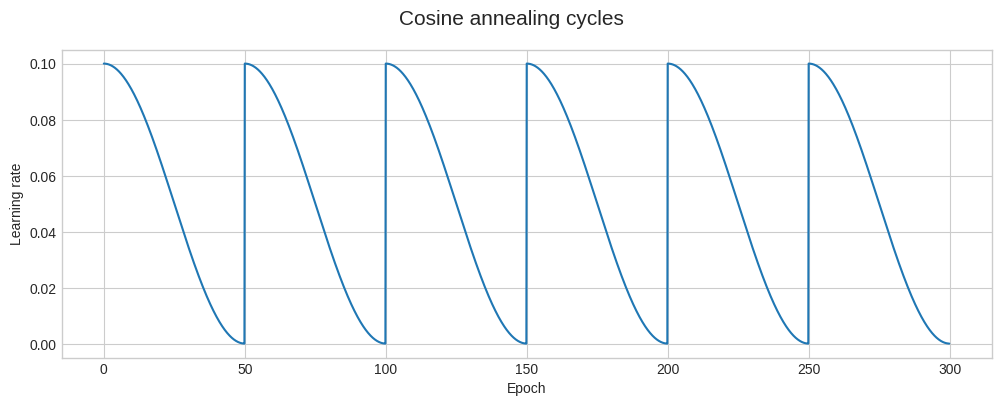

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# number of models (M in formula)
num_models = 6
# epoch per model
num_epochs = 50
# number of bats in dataset
len_dataset = 8

# total iteration number (T in formula)
total_iter = num_models * num_epochs * len_dataset

learning_rate_0 = 0.1

t = np.array(range(total_iter))
lr_t = (learning_rate_0 / 2) * (
    np.cos(np.pi * np.mod(t, total_iter / num_models) / (total_iter / num_models)) + 1
)

fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Cosine annealing cycles", size=15)
ax.plot(t / len_dataset, lr_t)
ax.set(xlabel="Epoch", ylabel="Learning rate")
plt.show()

В PyTorch циклический отжиг реализован в модуле `torch.optim.lr_scheduler.CosineAnnealingWarmRestarts`.

Общее правило подбора скорости обучения $\text{lr}_0$: она должна быть достаточно большой, чтобы “ломать” обученную модель, при этом количество эпох для обучения каждой модели должно быть достаточным для получения приличного качества. В [статье 🎓[article]](https://openreview.net/pdf?id=BJYwwY9ll), например, используют 50 эпох, но это значение зависит от модели.

In [ ]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=total_iter // num_models
)

Loss при обучении будет выглядеть примерно так (красная линия):

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/cosine_annealing_cycles.png" width="350"></center>

<center><em>Source: <a href="https://openreview.net/pdf?id=BJYwwY9ll">Snapshot Ensembles: train 1, get M for free</a></em></center>

Модели в конце цикла отжига сохраняются. Можно выбрать лучшую или построить ансамбль.


## Model soup

[[arxiv] 🎓 Model soups: averaging weights of multiple fine-tuned models improves accuracy without increasing inference time (2022)](https://arxiv.org/pdf/2203.05482.pdf)

В статье была предложена интересная идея ансамблирования моделей, названная “суп моделей”. Она очень проста: **обучить несколько моделей** (для этого будем использовать **циклический отжиг**) и **агрегировать веса моделей**, которые соответствуют нескольким различным минимумам функции потерь, в одну модель.

Для “приготовления супа” возьмем датасет CIFAR-10, который немного сложнее, чем рассматриваемый ранее MNIST.

In [ ]:
import torch
import random
import numpy as np


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

In [ ]:
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader, random_split


transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize([0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]),
    ]
)

cifar = datasets.CIFAR10("CIFAR10", train=True, download=True, transform=transform)
cifar_test = datasets.CIFAR10(
    "CIFAR10", train=False, download=True, transform=transform
)

train_set, val_set = random_split(cifar, [40_000, 10_000])

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=256, shuffle=False, num_workers=2)
test_loader = DataLoader(cifar_test, batch_size=256, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:04<00:00, 41.9MB/s]


Соберем простую модель:

In [ ]:
import torch.nn as nn


class SimpleNet_CIFAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.activation = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 2 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):  # input [batch, 3, 32, 32]
        x = self.activation(self.pool(self.conv1(x)))
        x = self.activation(self.pool(self.conv2(x)))
        x = self.activation(self.pool(self.conv3(x)))
        x = self.activation(self.fc1(x.flatten(start_dim=1)))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

Для обучения будем использовать Lightning, для расчета метрик — TorchMetrics. Это сделает код более универсальным (его можно использовать для ваших моделей с минимумом модификаций).

Для чтения логов будем использовать tbparse.

In [ ]:
!pip install -q lightning==2.5.0 tbparse

In [ ]:
import matplotlib.pyplot as plt
from tbparse import SummaryReader
from IPython.display import clear_output


def visualization(log_dir):
    # Visualization without TensorBoard for TensorBoard logs
    clear_output()
    reader = SummaryReader(log_dir)
    df = reader.scalars.drop_duplicates()

    uniq = set(df.tag.unique())
    uniq.remove("epoch")
    uniq = list(uniq)
    uniq.sort()

    i = 0
    ax_dict = {}
    for item in uniq:
        metric = item.split("/")[0]
        if metric not in ax_dict:
            ax_dict[metric] = i
            i += 1

    fig, axs = plt.subplots(len(ax_dict), 1, figsize=(12, 3.5 * len(ax_dict)))
    for item in uniq:
        metric = item.split("/")[0]
        ax = axs[ax_dict[metric]]
        sub_df = df[df["tag"] == item]
        ax.plot(sub_df.step, sub_df.value, label=item)
        ax.set_ylabel(metric)
        ax.legend()
        ax.set_xlabel("iter")
    plt.show()

Есть [несколько подходов 🎓[arxiv]](https://arxiv.org/pdf/2203.05482.pdf) к “приготовлению супа”. Мы рассмотрим два.

**Uniform soup** (равномерный суп) — веса всех моделей суммируются с одинаковым весом:
$$\text{Model} = f(x, \frac{1}{k}\sum_{i=1}^{k}ϴ_i)$$

**Greedy soup** (жадный суп):
1. Модели сортируются по убыванию качества **на валидационной** (**не на тестовой**) выборке.
2. Лучшая модель становится первым “ингредиентом” супа. Текущее качество “супа” определяется по значению метрики лучшей модели **на валидационной** выборке.
3. Остальные отсортированные модели по очереди добавляются в суп. Качество новой модели определяется по значению метрики **на валидационной** выборке. Если значение метрики новой модели лучше текущего качества супа, то модель добавляется в “суп”, а текущая метрика обновляется.

Качество “супа” определяется **на тестовой** выборке.

Код для методов реализован ниже. Для обучения отдельных моделей используется циклический отжиг.

In [ ]:
!mkdir ./soup_models_weights

In [ ]:
import lightning as L
from pathlib import Path
from torchmetrics import MetricCollection
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassF1Score,
    MulticlassAUROC,
)


class MakeSoup(L.LightningModule):
    def __init__(
        self,
        model,
        num_class,
        n_cycle_iter,
        cycle_epochs,
        show=True,
        soup_path="./soup_models_weights",
    ):
        super().__init__()
        self.cycle_epochs = cycle_epochs
        self.num_class = num_class
        self.n_cycle_iter = n_cycle_iter
        self.model = model
        self.show = show

        self.criterion = torch.nn.CrossEntropyLoss()

        # set metrics
        self.metrics = MetricCollection(
            [
                MulticlassAccuracy(
                    num_classes=num_class,
                ),
                # MulticlassF1Score(num_classes=num_class,),
                # MulticlassAUROC(num_classes=num_class,)
            ]
        )

        self.train_metrics = self.metrics.clone(postfix="/train")
        self.val_metrics = self.metrics.clone(postfix="/val")
        self.models_data = []
        self.soup_path = Path(soup_path)

    def configure_optimizers(self):
        # Set optimizer
        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=0.01,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer,
            T_0=self.n_cycle_iter,
            eta_min=0,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "step",  # or 'epoch'
                "frequency": 1,
            },
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)

        self.log("loss/train", loss, prog_bar=True, on_epoch=True, on_step=False)
        self.train_metrics.update(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        self.log("loss/val", loss, prog_bar=True, on_epoch=True, on_step=False)
        self.val_metrics.update(y_hat, y)

    def on_validation_epoch_end(self):
        val_metrics = self.val_metrics.compute()
        self.log_dict(val_metrics)
        self.val_metrics.reset()
        if self.trainer.ckpt_path is not None:
            self.models_data.append(
                {
                    "path": self.trainer.ckpt_path,
                    "metrics": {
                        key: val.cpu().item() for key, val in val_metrics.items()
                    },
                }
            )

    def on_train_epoch_end(self):
        self.log_dict(self.train_metrics.compute())
        self.train_metrics.reset()

        if self.show and self.current_epoch != 0:
            visualization(self.logger.log_dir)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        self.metrics.update(y_hat, y)

    def on_test_epoch_end(self):
        self.log_dict(self.metrics.compute())
        self.metrics.reset()

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)
        predict = y_hat.argmax(dim=1).detach().cpu()
        true = y.detach().cpu()

        return {
            "predict_label": predict,
            "true_label": true,
        }

    def uniform_soup(self, skip_first=False):
        self.models_data.sort(key=lambda x: x["path"], reverse=True)
        if skip_first:
            models_data = self.models_data[1:].copy()
        else:
            models_data = self.models_data.copy()
        n_model = len(models_data)
        for i, item in enumerate(models_data):
            checkpoint = torch.load(
                item["path"], weights_only=True, map_location=self.device
            )["state_dict"]
            state_dict = {
                key.removeprefix("model."): val for key, val in checkpoint.items()
            }
            if i == 0:
                uniform_soup_params = {
                    key: val * (1.0 / float(n_model)) for key, val in state_dict.items()
                }
            else:
                uniform_soup_params = {
                    key: val * (1.0 / float(n_model)) + uniform_soup_params[key]
                    for key, val in state_dict.items()
                }
            print(f'Adding {item["path"]} to soup.')
        self.model.load_state_dict(uniform_soup_params)
        path = self.soup_path / "model_uniform_soup.pt"
        torch.save(
            self.model.state_dict(),
            path,
        )
        return self.model

    def greedy_soup(self, val_loader, metric="MulticlassAccuracy"):
        # Sort
        self.models_data.sort(key=lambda x: x["metrics"][metric + "/val"], reverse=True)

        best_model_path = self.models_data[0]["path"]
        best_score = self.models_data[0]["metrics"][metric + "/val"]

        greedy_soup_ingredients = [best_model_path]

        checkpoint = torch.load(
            best_model_path, weights_only=True, map_location=self.device
        )["state_dict"]

        greedy_soup_params = {
            key.removeprefix("model."): val for key, val in checkpoint.items()
        }

        for i in range(1, len(self.models_data)):
            n = len(greedy_soup_ingredients)
            path = self.models_data[i]["path"]

            checkpoint = torch.load(path, weights_only=True, map_location=self.device)[
                "state_dict"
            ]

            ingredient_params = {
                key.removeprefix("model."): val for key, val in checkpoint.items()
            }

            # Mix ingredient
            potential_greedy_soup_params = {
                k: greedy_soup_params[k].clone() * (n / (n + 1.0))
                + ingredient_params[k].clone() * (1.0 / (n + 1.0))
                for k in ingredient_params
            }

            self.val_metrics.reset()
            self.model.load_state_dict(potential_greedy_soup_params)
            # Validate
            with torch.inference_mode():
                for batch_idx, batch in enumerate(val_loader):
                    self.test_step(batch, batch_idx)
                score = self.metrics.compute()[metric]
                self.metrics.reset()

            if score > best_score:
                greedy_soup_ingredients.append(path)
                best_score = score
                greedy_soup_params = potential_greedy_soup_params
                print(
                    f"Adding to soup. New soup is {greedy_soup_ingredients}. ",
                    f"With score = {best_score}",
                )

        self.model.load_state_dict(greedy_soup_params)
        path = self.soup_path / "model_greedy_soup.pt"
        torch.save(
            self.model.state_dict(),
            path,
        )
        return self.model

Параметры обучения представлены ниже. Запуск обучения закомментирован. Обучение модели занимает примерно 30 минут на GPU.

In [ ]:
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

L.seed_everything(42)

n_model = 5
cycle_epochs = 20
num_class = 10

model = SimpleNet_CIFAR()

n_cycle_iter = cycle_epochs * len(train_loader)

pl_model = MakeSoup(model, num_class, n_cycle_iter, cycle_epochs)

lr_monitor = LearningRateMonitor(logging_interval="step")
save_checkpoint = ModelCheckpoint(
    every_n_epochs=cycle_epochs,
    save_top_k=n_model,
    save_weights_only=True,
    monitor="MulticlassAccuracy/val",
    filename="model",
    mode="max",
)

trainer = L.Trainer(
    max_epochs=cycle_epochs * n_model,
    logger=L.pytorch.loggers.TensorBoardLogger(save_dir="./log/"),
    callbacks=[lr_monitor, save_checkpoint],
)

# trainer.fit(pl_model, train_loader, val_loader)

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Для ускорения работы мы загрузим заранее обученные модели и логи обучения:

In [ ]:
!wget -q https://edunet.kea.su/repo/EduNet-content/dev-2.3/L07/weights/model_soup_log.zip
!unzip -qq model_soup_log.zip

Загрузим модели, посчитаем статистику по предсказаниям и точность на выборке для валидации и загрузим последнее в нужное поле модели. Посмотрим на логи обучения.

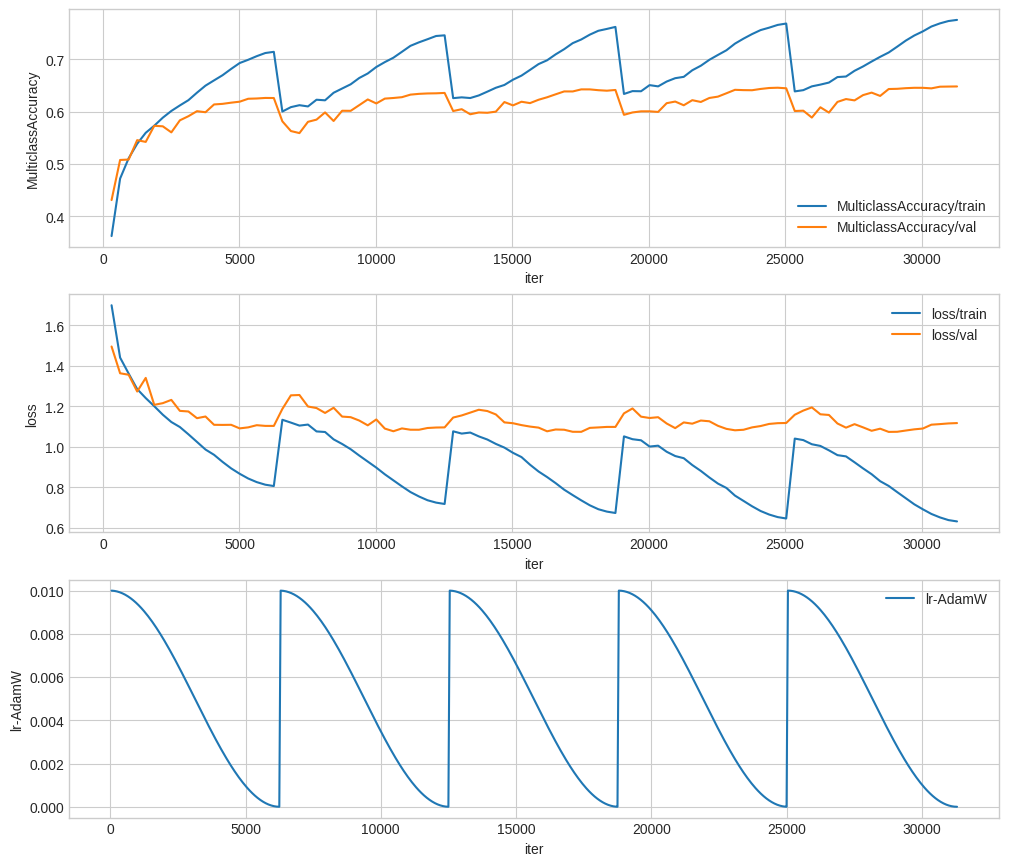

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  MulticlassAccuracy/val   │     0.635899007320404     │
│         loss/val          │    1.0963467359542847     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  MulticlassAccuracy/val   │    0.6415534615516663     │
│         loss/val          │    1.0986660718917847     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  MulticlassAccuracy/val   │     0.644766092300415     │
│         loss/val          │    1.1180671453475952     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  MulticlassAccuracy/val   │    0.6482957005500793     │
│         loss/val          │     1.117620587348938     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  MulticlassAccuracy/val   │    0.6261476278305054     │
│         loss/val          │    1.1035901308059692     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
import os


visualization("/content/model_soup_log/log/lightning_logs/version_0")
weights_path = Path("/content/model_soup_log/log/lightning_logs/version_0/checkpoints/")
file_list = os.listdir(weights_path)
file_list.sort()

for f in file_list:
    path = weights_path / f

    trainer.validate(
        model=pl_model,
        dataloaders=val_loader,
        ckpt_path=path,
    )

Мы сохранили пути до моделей и их точность:

In [ ]:
pl_model.models_data

[{'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.635899007320404}},
 {'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.6415534615516663}},
 {'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.644766092300415}},
 {'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.6482957005500793}},
 {'path': PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt'),
  'metrics': {'MulticlassAccuracy/val': 0.6261476278305054}}]

Посчитаем точность моделей на тестовой выборке:

In [ ]:
for f in file_list:
    path = weights_path / f

    trainer.test(
        model=pl_model,
        dataloaders=test_loader,
        ckpt_path=path,
    )

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6317999958992004     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6402999758720398     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6462000012397766     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6441000699996948     │
└───────────────────────────┴───────────────────────────┘

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6267000436782837     │
└───────────────────────────┴───────────────────────────┘

Лучшая модель имеет точность $64.62\%$.

Посчитаем точность на тестовой выборке в случае голосования моделей (выбирается класс, за который проголосовало большинство).

In [ ]:
import numpy as np


ans_statistic = np.zeros((n_model, len(cifar_test)))
true_label = np.zeros((len(cifar_test)))

for i, f in enumerate(file_list):
    path = weights_path / f

    prediction = trainer.predict(
        model=pl_model,
        dataloaders=test_loader,
        ckpt_path=path,
    )
    batch_size = prediction[0]["predict_label"].shape[0]
    for batsh_idx, items in enumerate(prediction):
        ans_statistic[i, batch_size * batsh_idx : batch_size * (batsh_idx + 1)] = items[
            "predict_label"
        ].numpy()
        true_label[batch_size * batsh_idx : batch_size * (batsh_idx + 1)] = items[
            "true_label"
        ].numpy()

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO: Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

Визуализируем предсказания наших $5$ моделей для первых $100$ объектов выборки для тестирования. Убедимся, что модели дают разные ответы, а значит их можно использовать для ансамбля.

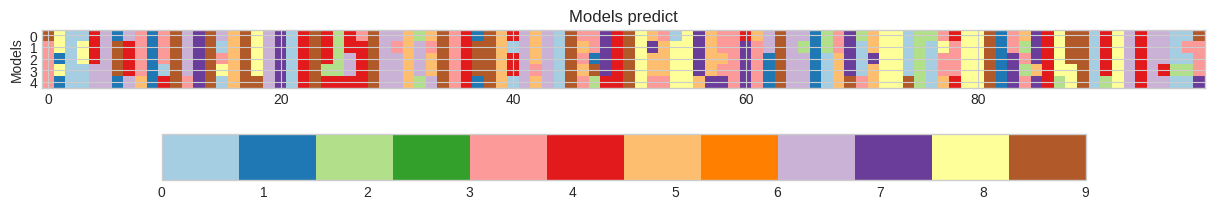

In [ ]:
plt.figure(figsize=(15, 4))
plt.imshow(ans_statistic[:, :100], cmap="Paired")
plt.colorbar(orientation="horizontal")
plt.title("Models predict")
plt.ylabel("Models")
plt.yticks(range(5))
plt.show()

In [ ]:
predict_label = np.zeros((len(cifar_test)))
for i in range(len(cifar_test)):
    values, counts = np.unique(ans_statistic[:, i], return_counts=True)
    predict_label[i] = values[counts.argmax()]
predict_label

array([3., 8., 0., ..., 5., 0., 7.])

In [ ]:
from sklearn.metrics import accuracy_score

print(f"Ensemble accuracy {accuracy_score(true_label, predict_label)}")

Ensemble accuracy 0.6567


Голосование моделей дает точность $65.67\%$. На $1.05\%$ лучше лучшей модели, но при этом на $1$ предсказание уходит в $5$ раз больше вычислительных ресурсов.

Попробуем применить `uniform_soup`:

In [ ]:
model = pl_model.uniform_soup()
trainer.test(pl_model, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt to soup.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6455999612808228     │
└───────────────────────────┴───────────────────────────┘

[{'MulticlassAccuracy': 0.6455999612808228}]

Точность хуже. Посмотрим на наши модели: первая модель имеет точность ниже, чем остальные. Это связано с тем, что она стартовала с худшей позиции.

Уберем эту модель из супа:

In [ ]:
model = pl_model.uniform_soup(skip_first=True)
trainer.test(pl_model, test_loader)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v2.ckpt to soup.
Adding /content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v1.ckpt to soup.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6483999490737915     │
└───────────────────────────┴───────────────────────────┘

[{'MulticlassAccuracy': 0.6483999490737915}]

Получили точность $64.84\%$. На $0.22\%$ лучше, чем у лучшей модели и на $0.83\%$ меньше, чем у голосования. При этом модель прогоняется только $1$ раз.

Попробуем `greedy_soup`:

In [ ]:
model = pl_model.greedy_soup(val_loader)
trainer.test(pl_model, test_loader)

Adding to soup. New soup is [PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v4.ckpt'), PosixPath('/content/model_soup_log/log/lightning_logs/version_0/checkpoints/model-v3.ckpt')].  With score = 0.6521247029304504


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.6484999656677246     │
└───────────────────────────┴───────────────────────────┘

[{'MulticlassAccuracy': 0.6484999656677246}]

Получили точность $64.85\%$. Это на $0.23\%$ лучше лучшей модели и на $0.82\%$ хуже голосования. При этом модель прогоняется только $1$ раз.

Таким образом, суп моделей является альтернативой ансамблированию методом голосования, позволяющей поднять точность предсказания без увеличения необходимых для Inference вычислительных ресурсов.

## Взаимодействие learning schedule и адаптивного изменения learning rate

И то, и другое меняет `learning rate`:

* `learning scheduler` — глобально,
* адаптивные оптимизаторы — для каждого веса отдельно.

Часто их применяют вместе, особенно в случае критерия ранней остановки и WarmUp.

Однако в случае циклического режима обучения так делают не всегда. Дело в том, что одна из его задач — как раз избежать использования адаптивных оптимизаторов, требующих больше памяти и дополнительных вычислений.

При этом никаких препятствий к использованию того же Adam в компании вместе с циклическим режимом обучения нет. Так делают, например, в [статье 🎓[arxiv]](https://arxiv.org/pdf/2004.02401.pdf).

Кроме того, есть сложные оптимизаторы, составленные из нескольких простых оптимизаторов и планировщиков. Например, есть проект [Ranger21 🐾[git]](https://github.com/lessw2020/Ranger21), не получивший оформления в виде библиотеки на [PyPi 🛠️[doc]](https://pypi.org/), авторы которого пытаются “померить” разные идеи из статей.

[[arxiv] 🎓 Ranger21: A Synergistic Deep Learning Optimizer (Wright, Demeure, 2021)](https://arxiv.org/pdf/2106.13731.pdf)

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.3/L07/ranger21.png" width="700"></center>

<center><em>Loss и accuracy при использовании Adam и Ranger21 при обучении ResNet50 на наборе данных ImageNet</em></center>

<center><em>Source: <a href="https://arxiv.org/pdf/2106.13731.pdf">Ranger21: A Synergistic Deep Learning Optimizer</a></em></center>

Результаты выглядят неплохо. Недостатком этого оптимизатора является большое количество хранимых параметров и гиперпараметров, а также тестирование на ограниченном числе моделей.

<font size=6>Литература</font>

<font size=5>Нормализация входов и выходов:</font>
* [[arxiv] 🎓 Multi-Task Learning for Multi-Dimensional Regression: Application to Luminescence Sensing (Umberto et al., 2020)](http://playground.tensorflow.org/#activation=linear&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.1&regularizationRate=0&noise=0&networkShape=&seed=0.62952&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)
* [[book] 📚 Dimensionless Equations](https://www.physics.umd.edu/perg/MathPhys/content/2/pstruc/dimsDE.htm)

<font size=5>Инициализация весов:</font>
* [[blog] ✏️ Почему инициализировать веса нейронной сети одинаковыми значениями (например, нулями) – это плохая идея](https://habr.com/ru/articles/592711/)
* [[article] 🎓 Understanding the difficulty of training deep feedforward neural networks (Xavier, Yoshua, 2010)](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)
* [[arxiv] 🎓 Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification (He et al., 2015)](https://arxiv.org/pdf/1502.01852v1.pdf)
* [[arxiv] 🎓 Exact solutions to the nonlinear dynamics of learning in
deep linear neural networks (Saxe et al., 2014)](https://arxiv.org/pdf/1312.6120.pdf)

<font size=5>Слои нормализации:</font>
* [[arxiv] 🎓 Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift (Ioffe, Szegedy, 2015)](https://arxiv.org/pdf/1502.03167.pdf)
* [[blog] ✏️ Deriving the Gradient for the Backward Pass of Batch Normalization](https://kevinzakka.github.io/2016/09/14/batch_normalization/)
* [[arxiv] 🎓How Does Batch Normalization Help Optimization? (Santurkar et al., 2019)](https://arxiv.org/pdf/1805.11604.pdf)
* [[article] 🎓 Список статей про различные виды нормализаций](https://paperswithcode.com/methods/category/normalization)
* [[article] 🎓 Dropout: A Simple Way to Prevent Neural Networks from Overfitting (Srivastava et al., 2014)](https://jmlr.org/papers/v15/srivastava14a.html)
* [[blog] ✏️ Dropout — метод решения проблемы переобучения в нейронных сетях](https://habr.com/ru/companies/wunderfund/articles/330814/)
* [[blog] ✏️ Tutorial: Dropout as Regularization and Bayesian Approximation](https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/)
* [[colab] 🥨 Batch Normalization and Dropout](https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/7_BatchNormalization/BatchNorm_Dropout.ipynb)
* [[arxiv] 🎓 Deep Networks with Stochastic Depth (Huang et al., 2016)](https://arxiv.org/pdf/1603.09382.pdf)
* [[arxiv] 🎓 Understanding the Disharmony between Dropout and Batch Normalization by Variance Shift (Li et al., 2018)](https://arxiv.org/pdf/1801.05134.pdf)
* [[git] 🐾 Understanding the Disharmony between Dropout and Batch Normalization](https://github.com/adelizer/kaggle-sandbox/blob/master/drafts/dropout_bn.ipynb)
* [[arxiv] 🎓 High-Performance Large-Scale Image Recognition Without Normalization (Brock et al., 2021)](https://arxiv.org/pdf/2102.06171.pdf)

<font size=5>Оптимизация параметров нейросетей:</font>
* [[article] 🎓 Список статей про различные алгоритмы оптимизации](https://paperswithcode.com/methods/category/stochastic-optimization)
* [[video] 📺 Градиентный спуск, как учатся нейронные сети](https://youtu.be/IHZwWFHWa-w)
* [[demo] 🎮 Optimizer Visualization](https://github.com/Jaewan-Yun/optimizer-visualization)
* [[article] 🎓 On the importance of initialization and momentum in deep learning](https://paperswithcode.com/methods/category/stochastic-optimization)
* [[arxiv] 🎓 Decoupled Weight Decay Regularization (Loshchilov, Hutter, 2019)](https://arxiv.org/pdf/1711.05101.pdf)
* [[arxiv] 🎓 Symbolic Discovery of Optimization Algorithms (Chen et al., 2023)](https://arxiv.org/pdf/2302.06675.pdf)
* [[arxiv] 🎓 PyGlove: Symbolic Programming for Automated Machine Learning (Peng et al., 2021)](https://arxiv.org/pdf/2101.08809.pdf)
* [[article] 🎓 Loss Surfaces, Mode Connectivity, and Fast Ensembling of DNNs](https://proceedings.neurips.cc/paper/2018/file/be3087e74e9100d4bc4c6268cdbe8456-Paper.pdf)
* [[blog] ✏️ Оптимизатор LBFGS](https://habr.com/ru/articles/333356/)

<font size=5>Режимы обучения:</font>
* [[arxiv] 🎓 Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour (Goyal et al., 2018)](https://arxiv.org/pdf/2101.08809.pdf)
* [[arxiv] 🎓 Cyclical Learning Rates for Training Neural Networks (Smith, 2017)](https://arxiv.org/pdf/1506.01186.pdf)
* [[arxiv] 🎓 SGDR: Stochastic Gradient Descent with Warm Restarts (Loshchilov, Hutter, 2017)](https://arxiv.org/pdf/1608.03983.pdf)
* [[article] Snapshot Ensembles: Train 1, get M for free (Huang et al., 2017)](https://openreview.net/pdf?id=BJYwwY9ll)
* [[colab] 🥨 Циклическое изменение learning rate для ускорения сходимости](https://colab.research.google.com/drive/1DYfhoazJ9AGT0IFcBIybpM7wn3DEIoFm)
* [[arxiv] 🎓 Model soups: averaging weights of multiple fine-tuned models improves accuracy without increasing inference time (Wortsman et el., 2022)](https://arxiv.org/pdf/2203.05482.pdf)
* [[arxiv] 🎓 Applying Cyclical Learning Rate to Neural Machine Translation (Lee et al., 2020)](https://arxiv.org/pdf/2203.05482.pdf)
* [[git] 🐾 Ranger21 — integrating the latest deep learning components into a single optimizer](https://github.com/lessw2020/Ranger21)
* [[arxiv] 🎓 Ranger21: A Synergistic Deep Learning Optimizer (Wright, Demeure, 2021)](https://arxiv.org/pdf/2106.13731.pdf)

<font size=5>Дополнительно:</font>
* [[blog] ✏️ A journey into Optimization algorithms for Deep Neural Networks](https://theaisummer.com/optimization/)
* [[blog] ✏️ In-layer normalization techniques for training very deep neural networks](https://theaisummer.com/normalization/)
* [[blog] ✏️ How Activation Functions Work in Deep Learning](https://www.kdnuggets.com/2022/06/activation-functions-work-deep-learning.html)
* [[demo] 🎮 Визуализация разных оптимизаторов в ipynb, но на tensorflow](https://nbviewer.jupyter.org/github/ilguyi/optimizers.numpy/blob/master/optimizer.tf.all.opt.plot.ipynb)